# Wind Energy Analysis for P2
## Lara NORMAND
## Datasets : Ouessant
### Date: [30/05/2025]

# 1 Study of your dataset

###  Load Data

#### Import libraries and load the datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from scipy.stats import weibull_min, kstest
from IPython.display import display
from scipy.interpolate import interp1d

First, lets load the file and look at what information it contains. Typically a CSV file has its first row listing the data names of the columns. 

In [2]:
#Load the CSV into a DataFrame
data_ouessant = "csv_Ouessant_48.455102_-5.097626_fixed_23_180_PT30M.csv"
ouessant = pd.read_csv(data_ouessant)

#Display the names of the column
print("Columns in the dataset:")
for col in ouessant.columns:
    print(f"- {col}")
print(f"\nTotal number of columns: {len(ouessant.columns)}")


Columns in the dataset:
- air_temp
- albedo
- azimuth
- clearsky_dhi
- clearsky_dni
- clearsky_ghi
- clearsky_gti
- cloud_opacity
- dewpoint_temp
- dhi
- dni
- ghi
- gti
- precipitable_water
- precipitation_rate
- relative_humidity
- surface_pressure
- snow_depth
- snow_water_equivalent
- snow_soiling_rooftop
- snow_soiling_ground
- wind_direction_100m
- wind_direction_10m
- wind_speed_100m
- wind_speed_10m
- zenith
- period_end
- period

Total number of columns: 28


## 1) Delete all non-wind-related and time-related features from your dataset

There is a total of 28 columns. Let's delete all non-wind-related and time-related features and clean them. 

In [3]:
#select the necessary columns (wind related and not time related)
wind_cols = [
    "wind_direction_10m",
    "wind_direction_100m",
    "wind_speed_10m",
    "wind_speed_100m",
    "period_end"
]

ouessant2 = ouessant[wind_cols]

#Verify the result
print(f"Columns kept: {ouessant2.columns.tolist()}")
display(ouessant2.head())


Columns kept: ['wind_direction_10m', 'wind_direction_100m', 'wind_speed_10m', 'wind_speed_100m', 'period_end']


,wind_direction_10m,wind_direction_100m,wind_speed_10m,wind_speed_100m,period_end
0,226,226,12.8,15.4,2014-01-01T00:30:00Z
1,222,222,12.4,15.0,2014-01-01T01:00:00Z
2,218,218,12.3,14.7,2014-01-01T01:30:00Z
3,214,215,12.2,14.7,2014-01-01T02:00:00Z
4,210,211,12.3,14.7,2014-01-01T02:30:00Z


Here we have kept 5 columns: 4 wind-related and 1 date related (stampdate and time).

Now let's see if there are any errors or missing datas in these columns.


In [4]:
print("ouessant2 Info:")
ouessant2.info()

#Count of missing/null values per column
null_counts = ouessant2.isnull().sum()
print("\nMissing / Null values per column:")
print(null_counts)

#Show rows that contain any nulls
rows_with_nulls = ouessant2[ouessant2.isnull().any(axis=1)]
if not rows_with_nulls.empty:
    print(f"\nRows with missing values (showing up to 5):")
    print(rows_with_nulls.head())
else:
    print("\nNo missing values found in any row.")

ouessant2 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175344 entries, 0 to 175343
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   wind_direction_10m   175344 non-null  int64  
 1   wind_direction_100m  175344 non-null  int64  
 2   wind_speed_10m       175344 non-null  float64
 3   wind_speed_100m      175344 non-null  float64
 4   period_end           175344 non-null  object 
dtypes: float64(2), int64(2), object(1)
memory usage: 6.7+ MB

Missing / Null values per column:
wind_direction_10m     0
wind_direction_100m    0
wind_speed_10m         0
wind_speed_100m        0
period_end             0
dtype: int64

No missing values found in any row.


We can see that there are no missing values

## 2) Extract a sub-dataset corresponding to exactly one year

As we can see the dataset it clean, now we want to save this as a new sub-dataset (corresponding to exactly one year). Here we are going to analyse the year 2023, the most recent complete year. 

In [5]:
ouessant2['period_end'] = pd.to_datetime(ouessant2['period_end'])

#Filter for rows where the year is 2023
O_2023 = ouessant2['period_end'].dt.year == 2023
ouessant_2023 = ouessant2.loc[O_2023].copy()

#create output path in the same directory as the original
output_path = Path(data_ouessant).parent / "csv_Ouessant_2023.csv"

#Save to CSV
ouessant_2023.to_csv(output_path, index=False)
print(f"Saved {len(ouessant_2023)} rows for 2023 to:\n{output_path}")

Saved 17520 rows for 2023 to:
csv_Ouessant_2023.csv


C:\Users\erwan\AppData\Local\Temp\ipykernel_27924\3129797097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ouessant2['period_end'] = pd.to_datetime(ouessant2['period_end'])


## 3) Plot the 4 wind-related features as a function of time spanning the whole year

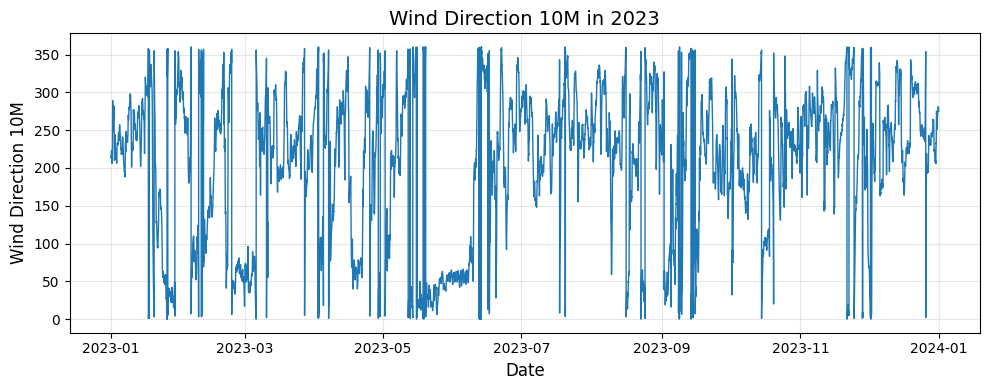

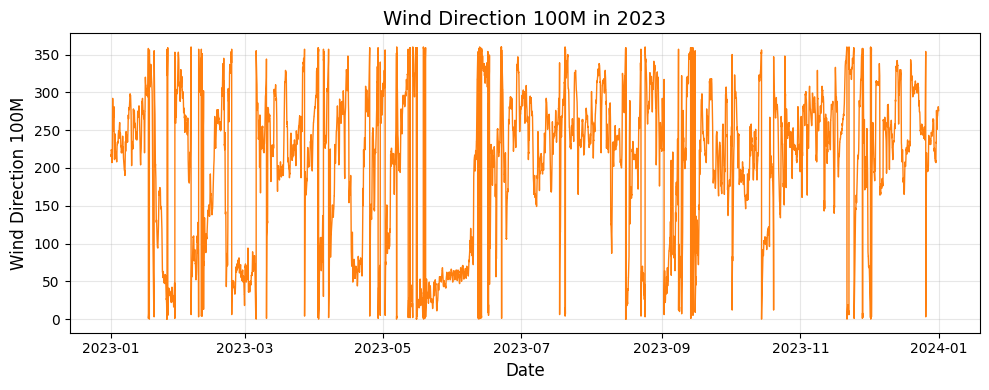

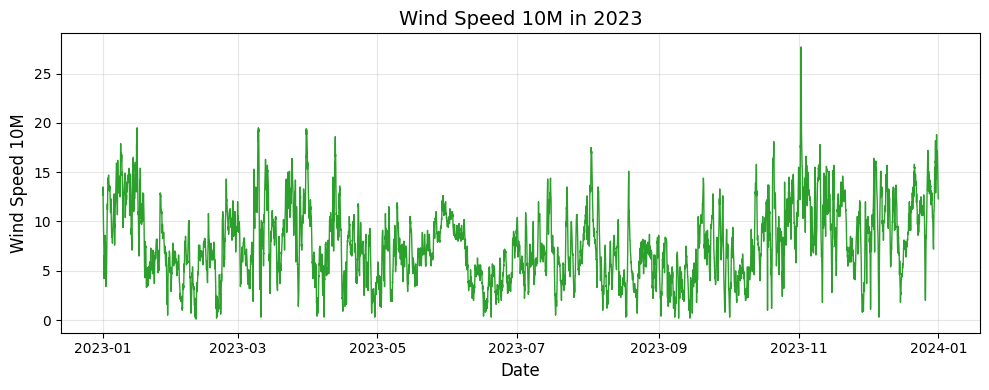

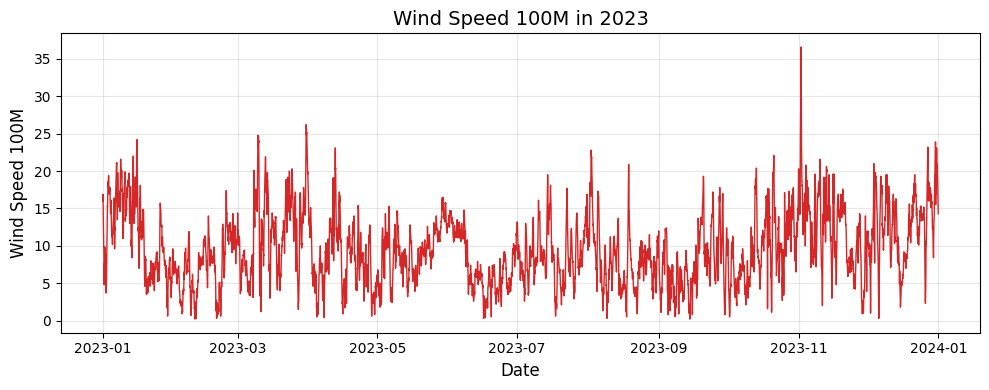

In [6]:
data_path = "csv_Ouessant_2023.csv"
subDS2023 = pd.read_csv(data_path, parse_dates=['period_end'])

#Makes sure that 'period_end' is datetime and sort chronologically
subDS2023['period_end'] = pd.to_datetime(subDS2023['period_end'])
subDS2023 = subDS2023.sort_values('period_end')

#Defining wind-related columns and assigning each one a unique color
wind_features = {
    'wind_direction_10m':   'tab:blue',
    'wind_direction_100m':  'tab:orange',
    'wind_speed_10m':       'tab:green',
    'wind_speed_100m':      'tab:red'
}

#Plot each feature 
for feature, color in wind_features.items():
    plt.figure(figsize=(10, 4))
    plt.plot(subDS2023['period_end'], subDS2023[feature], color=color, linewidth=1)
    plt.title(f"{feature.replace('_', ' ').title()} in 2023", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel(feature.replace('_', ' ').title(), fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


We can see from the graphs that: 
* wind directions at 10 and 100 meters is highly variable day-to-day and even hour-to-hour.
We can also visualy distinguish on the graph a stronger datapoint density around 250° (autumn and winter), which indicates predominantes winds coming from the South-West direction. Smaller datapoint clusters can be seen around 50° coming from the North-Est (during the end of spring).

* In general, wind speed ranges from 2m/s to 20m/s if we look at both graphs (10m and 100m). Both graphs closely match execpt for a scaling factor due to height measurement differences. This means the wind is homogenious at 10 and 100 meters, there doesn't seem to be any turbulances created from obstacles close the ground. This is expected as Ouessant does not have to many high buildings or trees. 
It is interesting to note that we can see the strong spike due to Ciaran storm early november 2023.

## 4) Calculate the number of hours during which the wind was not blowing

10 m (empirical) hours ≤ 3 m/s: 1425.0
10 m (Weibull)   hours ≤ 3 m/s: 1424.8

100 m (empirical) hours ≤ 3 m/s: 888.0
100 m (Weibull)   hours ≤ 3 m/s: 970.1



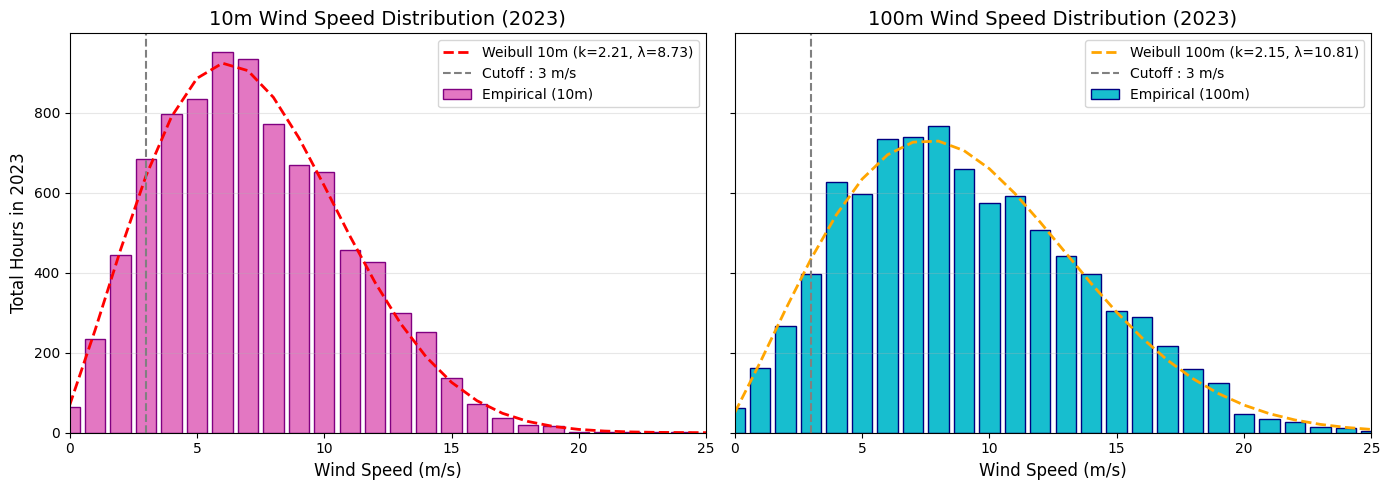

Comparison of empirical vs Weibull predicted hours


,Wind Speed (m/s),Empirical Hours (10m),Weibull Fit Hours (10m),Cumul Empirical 10m Hrs,Cumul Weibull 10m Hrs,Empirical Hours (100m),Weibull Fit Hours (100m),Cumul Empirical 100m Hrs,Cumul Weibull 100m Hrs
0,0,64.5,68.8,64.5,68.8,62.5,50.2,62.5,50.2
1,1,234.5,256.6,299.0,325.4,161.5,176.2,224.0,226.4
2,2,443.0,457.3,742.0,782.7,267.5,308.7,491.5,535.1
3,3,683.0,642.1,1425.0,1424.8,396.5,434.9,888.0,970.1
4,4,797.5,789.6,2222.5,2214.4,627.5,545.6,1515.5,1515.6


In [7]:

df = subDS2023.dropna(subset=['wind_speed_10m', 'wind_speed_100m'])

#Extracts the wind speed columns
ws_10m  = df['wind_speed_10m'].values
ws_100m = df['wind_speed_100m'].values

#Determine a common integer‐speed range (0 m/s up to ⌊max of both⌋ + 1)
max_speed_10  = np.floor(ws_10m.max())
max_speed_100 = np.floor(ws_100m.max())
max_speed = int(max(max_speed_10, max_speed_100))
bins = np.arange(0, max_speed + 2) 

#Digitize each wind speed array into the same integer bins
bin_idx_10  = np.digitize(ws_10m, bins) - 1
bin_idx_100 = np.digitize(ws_100m, bins) - 1

#Count how many 30 minute intervals fall into each integer speed bin
n_bins = len(bins) - 1
counts_10  = np.zeros(n_bins, dtype=int)
counts_100 = np.zeros(n_bins, dtype=int)

for idx in bin_idx_10:
    if 0 <= idx < n_bins:
        counts_10[idx] += 1

for idx in bin_idx_100:
    if 0 <= idx < n_bins:
        counts_100[idx] += 1


#Convert time into total hours 
hours_10  = counts_10  * 0.5  #counts of half an hour
hours_100 = counts_100 * 0.5

#Fit Weibull distributions 
speed_labels = np.arange(0, max_speed + 1) 
shape_k_10,  loc_10,  scale_10  = weibull_min.fit(ws_10m,  floc=0)
shape_k_100, loc_100, scale_100 = weibull_min.fit(ws_100m, floc=0)

#compute expected hours per speed bin
v_mid = speed_labels + 0.5 
pdf_10m  = weibull_min.pdf(v_mid, shape_k_10,  loc=0, scale=scale_10)
pdf_100m = weibull_min.pdf(v_mid, shape_k_100, loc=0, scale=scale_100)
total_halfhour_readings_10  = len(ws_10m)
total_halfhour_readings_100 = len(ws_100m)
total_hours_10  = total_halfhour_readings_10  * 0.5
total_hours_100 = total_halfhour_readings_100 * 0.5
hours_wbl_10  = pdf_10m  * total_hours_10
hours_wbl_100 = pdf_100m * total_hours_100

#cutoff at 3 m/s
v_cutoff = 3

#Compute cumulative sums for empirical and Weibull‐fit
cum_empirical_10  = np.cumsum(hours_10)
cum_empirical_100 = np.cumsum(hours_100)

cum_weibull_10  = np.cumsum(hours_wbl_10)
cum_weibull_100 = np.cumsum(hours_wbl_100)

emp_upto_3_10   = cum_empirical_10[v_cutoff]
wbl_upto_3_10   = cum_weibull_10[v_cutoff]
emp_upto_3_100  = cum_empirical_100[v_cutoff]
wbl_upto_3_100  = cum_weibull_100[v_cutoff]

print(f"10 m (empirical) hours ≤ {v_cutoff} m/s: {emp_upto_3_10:.1f}")
print(f"10 m (Weibull)   hours ≤ {v_cutoff} m/s: {wbl_upto_3_10:.1f}\n")
print(f"100 m (empirical) hours ≤ {v_cutoff} m/s: {emp_upto_3_100:.1f}")
print(f"100 m (Weibull)   hours ≤ {v_cutoff} m/s: {wbl_upto_3_100:.1f}\n")

#subplots to compare 10m vs 100m distributions,
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5), sharey=True)

#10m plot (empirical bars + Weibull fit)
ax1.bar(
    speed_labels,
    hours_10,
    color='tab:pink',
    edgecolor='purple',
    width=0.8,
    label="Empirical (10m)"
)
ax1.plot(
    speed_labels,
    hours_wbl_10,
    color='red',
    linestyle='--',
    linewidth=2,
    label=f"Weibull 10m (k={shape_k_10:.2f}, λ={scale_10:.2f})"
)
ax1.axvline(v_cutoff, color='gray', linestyle='--', label=f'Cutoff : {v_cutoff} m/s')
ax1.set_xlim(0, 25)
ax1.set_xticks(np.arange(0, 26, 5))
ax1.set_xlabel("Wind Speed (m/s)", fontsize=12)
ax1.set_ylabel("Total Hours in 2023", fontsize=12)
ax1.set_title("10m Wind Speed Distribution (2023)", fontsize=14)
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

#100m plot (empirical bars and Weibull fit)
ax2.bar(
    speed_labels,
    hours_100,
    color='tab:cyan',
    edgecolor='navy',
    width=0.8,
    label="Empirical (100m)"
)
ax2.plot(
    speed_labels,
    hours_wbl_100,
    color='orange',
    linestyle='--',
    linewidth=2,
    label=f"Weibull 100m (k={shape_k_100:.2f}, λ={scale_100:.2f})"
)
ax2.axvline(v_cutoff, color='gray', linestyle='--', label=f'Cutoff : {v_cutoff} m/s')
ax2.set_xlim(0, 25)  
ax2.set_xticks(np.arange(0, 26, 5))  
ax2.set_xlabel("Wind Speed (m/s)", fontsize=12)
ax2.set_title("100m Wind Speed Distribution (2023)", fontsize=14)
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

#compare both heights
comparison_df = pd.DataFrame({
    'Wind Speed (m/s)':            speed_labels,
    'Empirical Hours (10m)':      hours_10,
    'Weibull Fit Hours (10m)':    hours_wbl_10.round(1),
    'Cumul Empirical 10m Hrs':    cum_empirical_10,
    'Cumul Weibull 10m Hrs':      cum_weibull_10.round(1),
    'Empirical Hours (100m)':     hours_100,
    'Weibull Fit Hours (100m)':   hours_wbl_100.round(1),
    'Cumul Empirical 100m Hrs':   cum_empirical_100,
    'Cumul Weibull 100m Hrs':     cum_weibull_100.round(1)
})

print("Comparison of empirical vs Weibull predicted hours")
display(comparison_df.head())


To calculate the number of hours, We have first plotted the distribution of the wind speed (m/s) in function of hours for both 10m and 100m. We have then fitted a weibull distribution to the chart because it smooths sampling noise into a continuous curve. This allows us to then decide what would be the appropriate wind speed cut-off for when the wind is considered not blowing. Looking at the datasheet of the wind turbines in this exercise, We can see that the average turbine is not producing any energy under 3m/s. This will be our cut-off.

We can then, from there look at the cumulative hours under that (or any) value when the wind is not blowing. 

* At 10m, the data show a total of 1 425h below the 3 m/s cut-off. The Weibull fit slightly overestimates the 0–2 m/s bars but underestimates the 2–3 m/s bar so that its cumulative prediction at 3 m/s (1 424.8h, about 16% of the year) matches almost exactly. 
* At 100 m, the data show a total of 888h (about 10% of the year) below 3 m/s, while the Weibull model predicts about 970h, overestimating by around 82h. 

We can observe the results are different at 10m and 100m, this would be expected since there are stronger winds at 100m.
Therefore, depending on the mast height of the chosen wind turbine we need to take that into consideration. 

## 5) Plot the monthly-averaged wind-related features as a function of the number of the month

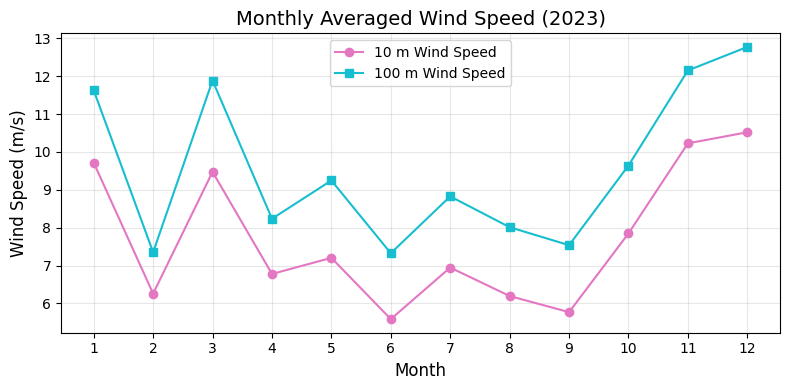

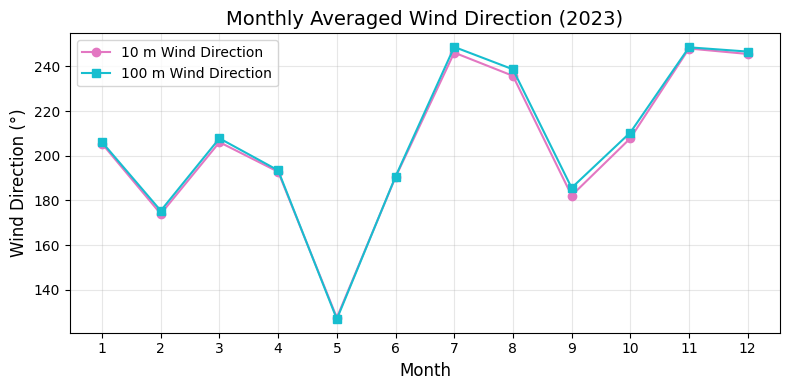

In [8]:
subDS2023['period_end'] = pd.to_datetime(subDS2023['period_end'])

#Extract month number for each row
subDS2023['month'] = subDS2023['period_end'].dt.month

#Compute monthly means for the 4 wind related columns
wind_cols = [
    'wind_direction_10m',
    'wind_direction_100m',
    'wind_speed_10m',
    'wind_speed_100m'
]
monthly_means = subDS2023.groupby('month')[wind_cols].mean()

#define x‐axis (months 1–12)
months = monthly_means.index 

#plot Monthly Wind Speed (10m vs 100m)
plt.figure(figsize=(8, 4))
plt.plot(
    months,
    monthly_means['wind_speed_10m'],
    marker='o',
    color='tab:pink',
    label='10 m Wind Speed'
)
plt.plot(
    months,
    monthly_means['wind_speed_100m'],
    marker='s',
    color='tab:cyan',
    label='100 m Wind Speed'
)
plt.title('Monthly Averaged Wind Speed (2023)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Wind Speed (m/s)', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


#Plot Monthly Wind Direction (10m vs 100m) 
plt.figure(figsize=(8, 4))
plt.plot(
    months,
    monthly_means['wind_direction_10m'],
    marker='o',
    color='tab:pink',
    label='10 m Wind Direction'
)
plt.plot(
    months,
    monthly_means['wind_direction_100m'],
    marker='s',
    color='tab:cyan',
    label='100 m Wind Direction'
)
plt.title('Monthly Averaged Wind Direction (2023)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Wind Direction (°)', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


The wind‐speed plot shows a clear and similar seasonal cycle at both heights. The Speeds peak in winter, drop in February, then rise again in early spring, and reach their minimum in June. Afterward, speeds climb through autumn, reaching their highest values in December. Throughout the year, the 100m readings remain about 1 to 2 m/s higher than the 10 m readings, as expected with increasing height. 

The wind-direction plot also displays a seasonal cycle that’s almost identical at 10m and 100m (which is expected). We can see with this pattern that a South-Western flow dominates most of the year, with only a short South-Eastern interval in late spring.

## 6) Plot the wind speed distribution at 10m and 100m above the ground

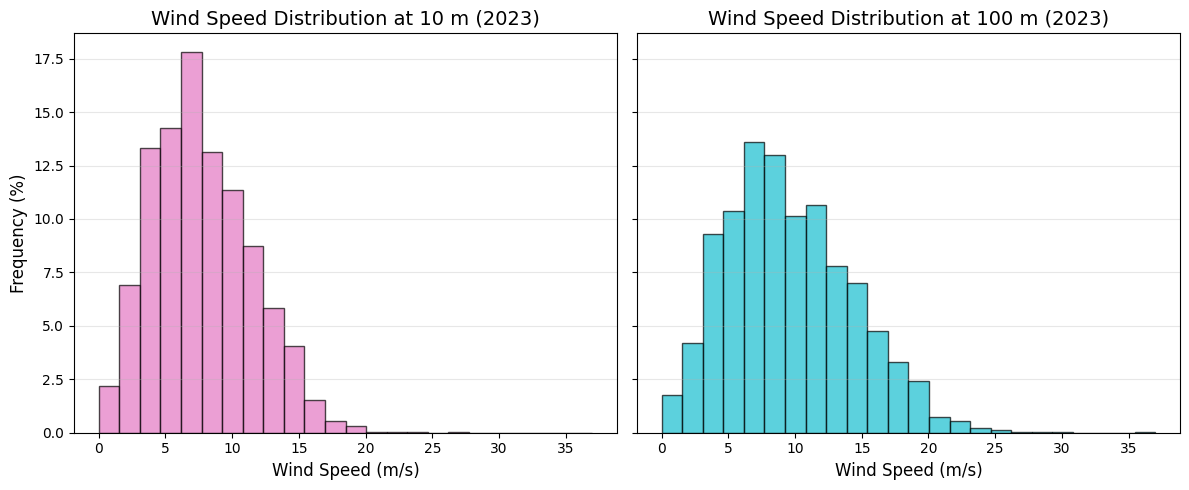

In [9]:

#Extract the wind speed arrays for 10m and 100m
ws_10m  = df['wind_speed_10m'].values
ws_100m = df['wind_speed_100m'].values

#Define speed bins (24 bins)
bin_max = np.ceil(max(ws_10m.max(), ws_100m.max()))
bins = np.linspace(0, bin_max, 25)  

#Weights to normalize histograms to percentages
weights_10m  = np.ones_like(ws_10m)  * (100.0 / len(ws_10m))
weights_100m = np.ones_like(ws_100m) * (100.0 / len(ws_100m))

#Plot frequency histograms
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)

#10m
ax1.hist(
    ws_10m,
    bins=bins,
    weights=weights_10m,
    alpha=0.7,
    color='tab:pink',
    edgecolor='black'
)
ax1.set_title("Wind Speed Distribution at 10 m (2023)", fontsize=14)
ax1.set_xlabel("Wind Speed (m/s)", fontsize=12)
ax1.set_ylabel("Frequency (%)", fontsize=12)
ax1.grid(axis='y', alpha=0.3)


#100m 
ax2.hist(
    ws_100m,
    bins=bins,
    weights=weights_100m,
    alpha=0.7,
    color='tab:cyan',
    edgecolor='black'
)
ax2.set_title("Wind Speed Distribution at 100 m (2023)", fontsize=14)
ax2.set_xlabel("Wind Speed (m/s)", fontsize=12)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


At 10m (green), the most common wind speeds are around 7 to 8 m/s, with the majority of the datapoints between 5 and 10m/s. We can see that very low speeds (< 3 m/s) occur under 16 % of the time, as we have seen above for the cut-off threshold. It aslo hardly exceeds 15 m/s.

At 100m (blue), the peak shifts to 9-10 m/s, with the majority of the datapoints between 6 and 12m/s. Speeds < 3m/s are now under 10 %. High‐speed winds (> 15 m/s) are more prevalent in this case, explaining why high hub wind turbines are more productive.

## 7) Find the parameters of the Weibull distribution that seems to fit best your data

10 m: shape (k) = 2.2148, scale (λ) = 8.7266
100 m: shape (k) = 2.1537, scale (λ) = 10.8118



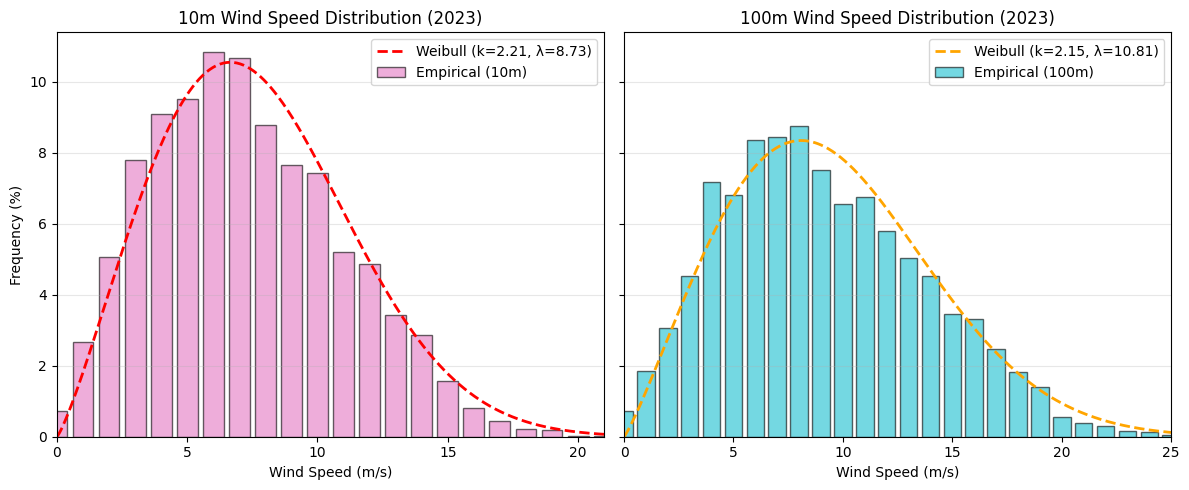

In [10]:
#Define integer bins (0–26) and midpoints (0.5, 1.5, ..., 25.5)
v_bins = np.arange(0, 27, 1)
v_mid  = v_bins + 0.5

#Compute empirical frequency (%) per bin
counts_10m, _  = np.histogram(ws_10m,  bins=np.append(v_bins, np.inf))
counts_100m, _ = np.histogram(ws_100m, bins=np.append(v_bins, np.inf))
n10 = len(ws_10m)
n100 = len(ws_100m)
freq_pct_emp_10m  = 100 * counts_10m  / n10
freq_pct_emp_100m = 100 * counts_100m / n100

#Fit Weibull distributions
shape10, loc10, scale10   = weibull_min.fit(ws_10m,  floc=0)
shape100, loc100, scale100 = weibull_min.fit(ws_100m, floc=0)
print(f"10 m: shape (k) = {shape10:.4f}, scale (λ) = {scale10:.4f}")
print(f"100 m: shape (k) = {shape100:.4f}, scale (λ) = {scale100:.4f}\n")

#compute PDFs and scale to percent
x_dense = np.linspace(0, 26, 400)
pdf10 = weibull_min.pdf(x_dense, shape10, loc=0, scale=scale10)
pdf100 = weibull_min.pdf(x_dense, shape100, loc=0, scale=scale100)
curve10 = 100 * pdf10
curve100 = 100 * pdf100

#Plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5), sharey=True)

#10m graph
ax1.bar(
    v_bins,
    freq_pct_emp_10m,
    width=0.8,
    color='tab:pink',
    edgecolor='black',
    alpha=0.6,
    label='Empirical (10m)'
)
ax1.plot(
    x_dense,
    curve10,
    'r--',
    linewidth=2,
    label=f'Weibull (k={shape10:.2f}, λ={scale10:.2f})'
)
ax1.set_xlim(0,21)
ax1.set_xticks(np.arange(0,21,5))
ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Frequency (%)')
ax1.set_title('10m Wind Speed Distribution (2023)')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

#100m graph
ax2.bar(
    v_bins,
    freq_pct_emp_100m,
    width=0.8,
    color='tab:cyan',
    edgecolor='black',
    alpha=0.6,
    label='Empirical (100m)'
)
ax2.plot(
    x_dense,
    curve100,
    'orange',
    linestyle='--',
    linewidth=2,
    label=f'Weibull (k={shape100:.2f}, λ={scale100:.2f})'
)
ax2.set_xlim(0,25)
ax2.set_xticks(np.arange(0,26,5))
ax2.set_xlabel('Wind Speed (m/s)')
ax2.set_title('100m Wind Speed Distribution (2023)')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


As seen in our previous comment,the fitted Weibull curves peak at 7–8m/s for 10m and 9–10m/s for 100m. The 10m curve has a small tail beyond 15m/s, while the 100m curve still shows high speed wind after that value, confirming that strong winds at high altitude are more frequent.

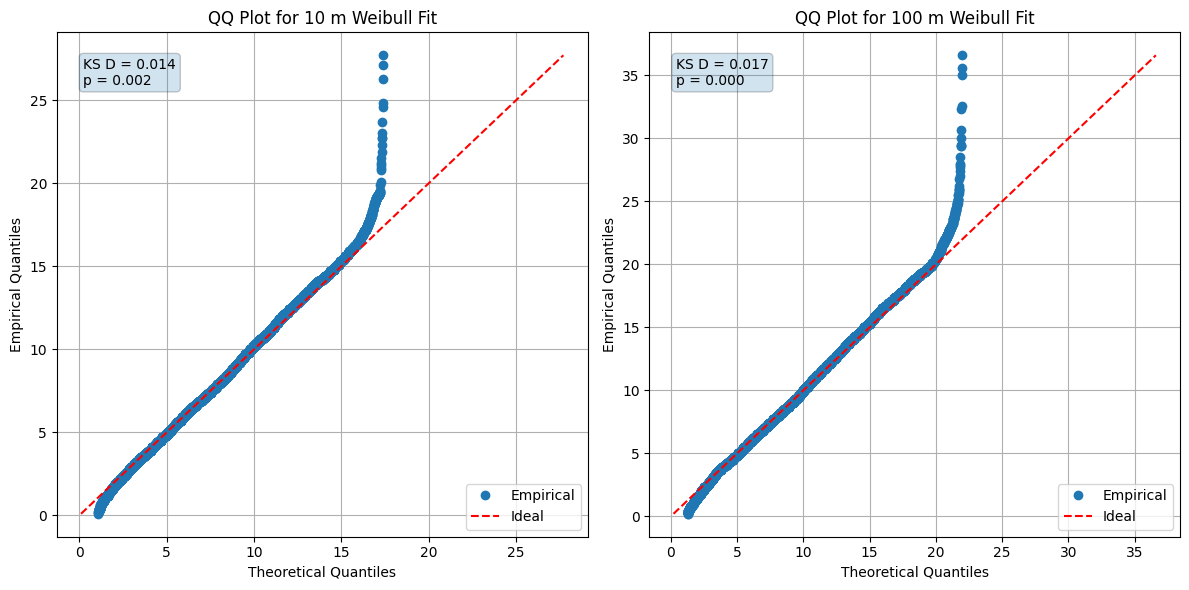

In [11]:
def plot_weibull_qq(ws, shape, scale, ax, title):
    D, p = kstest(ws, 'weibull_min', args=(shape, 0, scale)) #Kolmogorov–Smirnov test for goodness of fit
    ax.text(0.05, 0.95,
            f"KS D = {D:.3f}\np = {p:.3f}",
            transform=ax.transAxes,
            va='top',
            bbox=dict(boxstyle='round', alpha=0.2))
    
    #QQ data
    sorted_data = np.sort(ws)
    theor_q = weibull_min.ppf(np.linspace(0.01, 0.99, len(ws)), shape, loc=0, scale=scale)
    
    #Plot the QQ
    ax.plot(theor_q, sorted_data, 'o', label='Empirical')
    ax.plot(sorted_data, sorted_data, 'r--', label='Ideal')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Empirical Quantiles')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

#plot both graphs
shape10, _, scale10   = weibull_min.fit(ws_10m,  floc=0)
shape100, _, scale100 = weibull_min.fit(ws_100m, floc=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharex=False, sharey=False)

plot_weibull_qq(ws_10m,  shape10,  scale10,  ax1, 'QQ Plot for 10 m Weibull Fit')
plot_weibull_qq(ws_100m, shape100, scale100, ax2, 'QQ Plot for 100 m Weibull Fit')

plt.tight_layout()
plt.show()

We can see from the plots that Weibull distribution provides a generally good fit for wind speed data between approximately 2m/s and 20m/s. However, we can notice that deviations become noticeable at the lower and upper ends of the wind speed range.

* At low wind speed (< 2m/s): We can observe that the Weibull fit tends to overestimate and this is probably due to sensor (anemometer) friction at very low speeds (<0.5m/s), where the rotor may not spin. Also possibly nonlinear sensor reponse or most likely because of sparse empirical data at low wind speeds.
 
* At high wind speeds (> 20m/s): We can see that at the upper end, the Weibull fit tends to underestimate. The reasons behind this are probably because extreme wind events are rare and also possible sensor saturation, where it becomes less accurate at very high speeds due to mechanical stress.

However, most wind turbines have cut-in speeds between 2–3m/s and cut-out speeds between 20–25m/s.
As a result, the observed mismatch of the tails of the distribution can be ignored for our futur energy and capacity factor calculations.
 

## what is the effect of the wind direction, and how should you take that into account when installing your wind turbine?

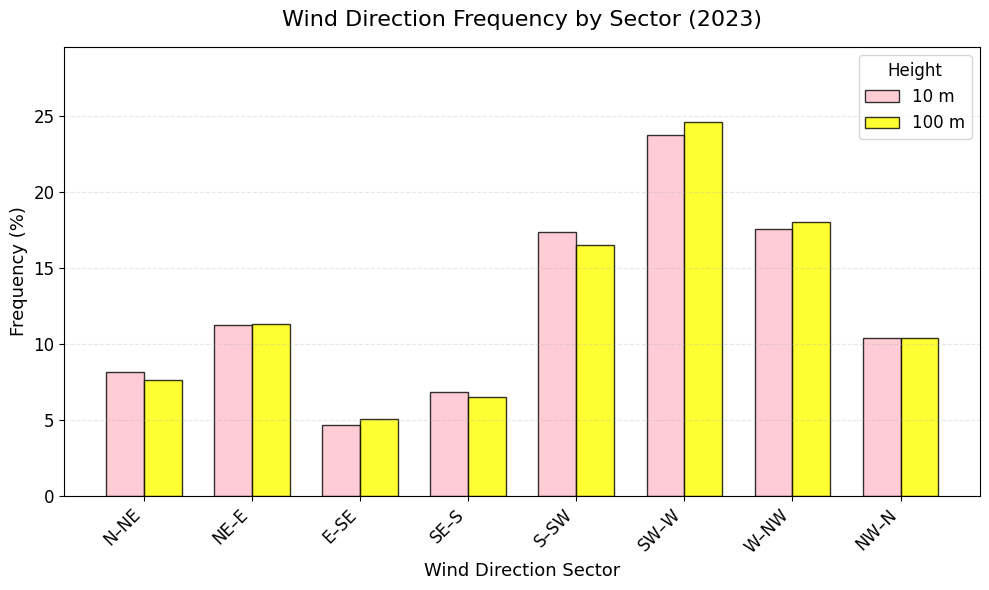

In [12]:
#Extract direction arrays (ensure values in [0,360))
dir_10m  = df['wind_direction_10m'].values % 360
dir_100m = df['wind_direction_100m'].values % 360

#Define 45° wind direction sectors and calculate percent per sector
sector_edges  = np.arange(0, 361, 45)
sector_labels = ['N–NE', 'NE–E', 'E–SE', 'SE–S', 'S–SW', 'SW–W', 'W–NW', 'NW–N']

def sector_frequencies(directions):
    counts, _ = np.histogram(directions, bins=sector_edges)
    freqs_pct = 100 * counts / len(directions)
    return freqs_pct

freq_10m  = sector_frequencies(dir_10m)
freq_100m = sector_frequencies(dir_100m)

#Plot both graphs
x = np.arange(len(sector_labels)) 
bar_width = 0.35

plt.figure(figsize=(10, 6))
#10m
plt.bar(
    x - bar_width/2,
    freq_10m,
    width=bar_width,
    color="pink",       
    edgecolor='black',
    alpha=0.8,
    label='10 m'
)

#100m 
plt.bar(
    x + bar_width/2,
    freq_100m,
    width=bar_width,
    color= "yellow",       
    edgecolor='black',
    alpha=0.8,
    label='100 m'
)

plt.xticks(x, sector_labels, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Wind Direction Sector', fontsize=13)
plt.ylabel('Frequency (%)', fontsize=13)
plt.title('Wind Direction Frequency by Sector (2023)', fontsize=16, pad=15)
plt.ylim(0, max(freq_10m.max(), freq_100m.max()) * 1.2)  #give some headroom
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(title='Height', fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()


The frequency of the wind direction graph above shows us where most of the energy comes from in Ouessant, here around 200°–250° (SW-W) at both 10m and 100m.
If we orientate the turbine toward SW-W, it will capture the strongest winds most of the time. 
Our previous analyses also showed that in Ouessant there are few turbulances at 10m high (wind direction matches closely the 100m height), so there are less constraints to locate the wind turbine on the island (no high buildings or trees...).

To conclude, to optimize the turbines, they should be facing SW-W and outside the village.




## 8) Find the height of the mast for each of these turbines, and add a feature to your dataframe containing the wind speed at this height according to the wind log profile formula, and justify your assumption on the value of the zero-plane displacement

### - Data extraction

Sources used:

https://www.thewindpower.net/turbine_en_846_alstom-power_122.php 

https://www.thewindpower.net/turbine_en_1_enercon_e33-330.php 

https://eawe.eu/site/assets/files/downloads/committees/twtc/TWTC-ETH-aventa-research-wind-turbine.pdf

https://wind-data.ch/tools/powercalc.php

In [13]:
def get_turbines():
    return {
        'Alstom_ECO122': {
            'rated_power': 2700,  # kW
            'hub_height': 89,     # m
            'cut_in_speed': 3.0,  # m/s
            'rated_speed': 13.0,  # m/s
            'cut_out_speed': 25.0,# m/s
            'power_curve': {
                1: 0,   2: 0, 3: 29, 4: 171, 5: 389,
                6: 703, 7: 1130,8: 1682, 9: 2205,10: 2541,
                11: 2669,12: 2697,13: 2700,14: 2700,15: 2700,
                16: 2700,17: 2700,18: 2700,19: 2700,20: 2700,
                21: 2700,22: 2700,23: 2700,24: 2700,25: 2700,
                26: 0,   27: 0,   28: 0,   29: 0,   30: 0
            }
        },
        'Enercon_E33': {
            'rated_power': 330,  
            'hub_height': 37,    
            'cut_in_speed': 2.5, 
            'rated_speed': 13.0, 
            'cut_out_speed': 25.0,
            'power_curve': {
                1: 0,    2: 0,    3: 2.5,  4: 14,   5: 30,
                6: 55,   7: 92,   8: 138,  9: 196,  10: 250,
                11: 292.8,12: 320, 13: 335, 14: 335, 15: 335,
                16: 335, 17: 335, 18: 335, 19: 335, 20: 335,
                21: 335, 22: 335, 23: 335, 24: 335, 25: 335,
                26: 0,   27: 0,   28: 0,   29: 0,   30: 0
            }
        },
        'Aventa_AV7': {
            'rated_power': 6.5,    
            'hub_height': 18,      
            'cut_in_speed': 2.0,   
            'rated_speed': 7.0,    
            'cut_out_speed': 14.0,
            'power_curve': {
                1: 0,   2: 0.1, 3: 0.7, 4: 1.5, 5: 3.1,
                6: 5.8, 7: 6.2, 8: 6.2, 9: 6.2, 10: 6.2,
                11: 6.2,12: 6.2,13: 6.2,14: 6.2,15: 0,
                16: 0,  17: 0,  18: 0,  19: 0,  20: 0,
                21: 0,  22: 0,  23: 0,  24: 0,  25: 0,
                26: 0,  27: 0,  28: 0,  29: 0,  30: 0
            }
        }
    }

turbines = get_turbines()
turbine_specs = {
    'Alstom_ECO122': 2700,    # kW
    'Enercon_E33': 330,     
    'Aventa_AV7': 6.5        
}

spec_rows = []
for name, specs in turbines.items():
    spec_rows.append({
        'Turbine': name,
        'Rated Power (kW)': specs['rated_power'],
        'Hub Height (m)': specs['hub_height'],
        'Cut-in Speed (m/s)': specs['cut_in_speed'],
        'Rated Speed (m/s)': specs['rated_speed'],
        'Cut-out Speed (m/s)': specs['cut_out_speed']
    })

spec_df = pd.DataFrame(spec_rows).set_index('Turbine')
display(spec_df)

,Rated Power (kW),Hub Height (m),Cut-in Speed (m/s),Rated Speed (m/s),Cut-out Speed (m/s)
Turbine,,,,,
Alstom_ECO122,2700.0,89,3.0,13.0,25.0
Enercon_E33,330.0,37,2.5,13.0,25.0
Aventa_AV7,6.5,18,2.0,7.0,14.0


### - Wind speed calculation using the wind-log formula

For the wind-log formula we will be using a zero plane displacement height (d=0). Since there are no tall buildings or no tall trees on Ouessant, therefore no significant obstacles, we can assume d=0. 


In [14]:
turbines = get_turbines() 

#Define constants and turbine heights
kappa = 0.41       #von Kármán constant
z1 = 10.0         #reference height 1 (m)
z2 = 100.0        #reference height 2 
d  = 0.0          #zero‐plane displacement 

hub_heights = {
    'Alstom_ECO122': 89.0,
    'Enercon_E33':   37.0,
    'Aventa_AV7':    18.0
}

#Compute friction velocity u* at each timestamp
#using u(z2) and u(z1), u* = κ [u(z2) − u(z1)] / ln((z2−d)/(z1−d))
u10  = subDS2023['wind_speed_10m'].values
u100 = subDS2023['wind_speed_100m'].values
ln_ratio = np.log((z2 - d) / (z1 - d))
ustar = kappa * (u100 - u10) / ln_ratio

#estimate u(h) at any hub height h
for name, h in hub_heights.items():
    col = f'wind_speed_{name}_from_logprofile'
    subDS2023[col] = u10 + (ustar / kappa) * np.log(h / z1)

#Save the augmented dataset to a new CSV
output_filename = 'csv_Ouessant_2023_with_hub_speeds.csv'
subDS2023.to_csv(output_filename, index=False)

display(subDS2023[[
    'period_end',
    'wind_speed_10m',
    'wind_speed_100m',
    'wind_speed_Alstom_ECO122_from_logprofile',
    'wind_speed_Enercon_E33_from_logprofile',
    'wind_speed_Aventa_AV7_from_logprofile'
]].head())

,period_end,wind_speed_10m,wind_speed_100m,wind_speed_Alstom_ECO122_from_logprofile,wind_speed_Enercon_E33_from_logprofile,wind_speed_Aventa_AV7_from_logprofile
0,2023-01-01 00:00:00+00:00,12.7,16.0,15.832987,14.575066,13.542399
1,2023-01-01 00:30:00+00:00,12.8,16.3,16.122865,14.788706,13.693454
2,2023-01-01 01:00:00+00:00,13.0,16.6,16.417804,15.045526,13.918981
3,2023-01-01 01:30:00+00:00,13.2,16.8,16.617804,15.245526,14.118981
4,2023-01-01 02:00:00+00:00,13.4,16.9,16.722865,15.388706,14.293454


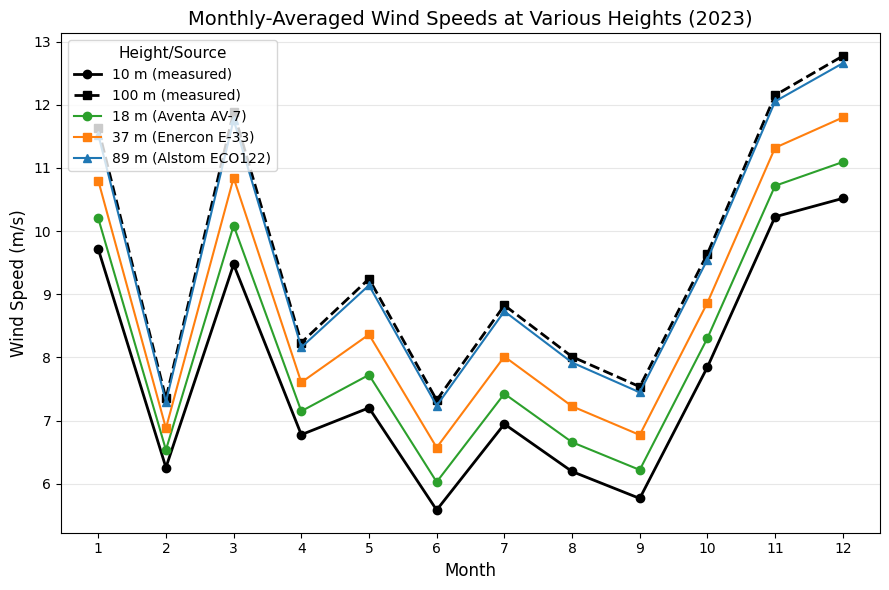

In [15]:
#Load new csv + parse dates
df = pd.read_csv('csv_Ouessant_2023_with_hub_speeds.csv', parse_dates=['period_end'])

#Extract month number from 'period_end'
df['month'] = df['period_end'].dt.month

#Specify the columns to average (10m, 100m and 3 hub heights)
cols_to_plot = {
    '10 m (measured)':             'wind_speed_10m',
    '100 m (measured)':            'wind_speed_100m',
    '18 m (Aventa AV-7)':          'wind_speed_Aventa_AV7_from_logprofile',
    '37 m (Enercon E-33)':         'wind_speed_Enercon_E33_from_logprofile',
    '89 m (Alstom ECO122)':        'wind_speed_Alstom_ECO122_from_logprofile'
}

#Compute monthly means for each selected column
monthly_means = df.groupby('month')[list(cols_to_plot.values())].mean()

#Plot monthly average wind speeds
months = monthly_means.index  

plt.figure(figsize=(9, 6))

#Plot 10m & 100m (black lines)
plt.plot(
    months,
    monthly_means['wind_speed_10m'],
    color='black',
    linestyle='-',
    linewidth=2,
    marker='o',
    label='10 m (measured)'
)
plt.plot(
    months,
    monthly_means['wind_speed_100m'],
    color='black',
    linestyle='--',
    linewidth=2,
    marker='s',
    label='100 m (measured)'
)

#Plot hub‐height log‐profile estimates (coloured)
plt.plot(
    months,
    monthly_means['wind_speed_Aventa_AV7_from_logprofile'],
    color='tab:green',
    linestyle='-',
    marker='o',
    label='18 m (Aventa AV-7)'
)
plt.plot(
    months,
    monthly_means['wind_speed_Enercon_E33_from_logprofile'],
    color='tab:orange',
    linestyle='-',
    marker='s',
    label='37 m (Enercon E-33)'
)
plt.plot(
    months,
    monthly_means['wind_speed_Alstom_ECO122_from_logprofile'],
    color='tab:blue',
    linestyle='-',
    marker='^',
    label='89 m (Alstom ECO122)'
)

plt.title('Monthly-Averaged Wind Speeds at Various Heights (2023)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Wind Speed (m/s)', fontsize=12)
plt.xticks(range(1, 13))
plt.grid(axis='y', alpha=0.3)
plt.legend(loc='upper left', fontsize=10, title='Height/Source', title_fontsize=11)
plt.tight_layout()
plt.show()


Using the wind-log profile formula, we have now imported the wind speed at hub height for our 3 turbines into a new dataset. 

## 9) Adding any other relevant feature to your dataframe, calculate the number of operating hours, the total power production in kWh/year and the capacity factor with each wind turbine model


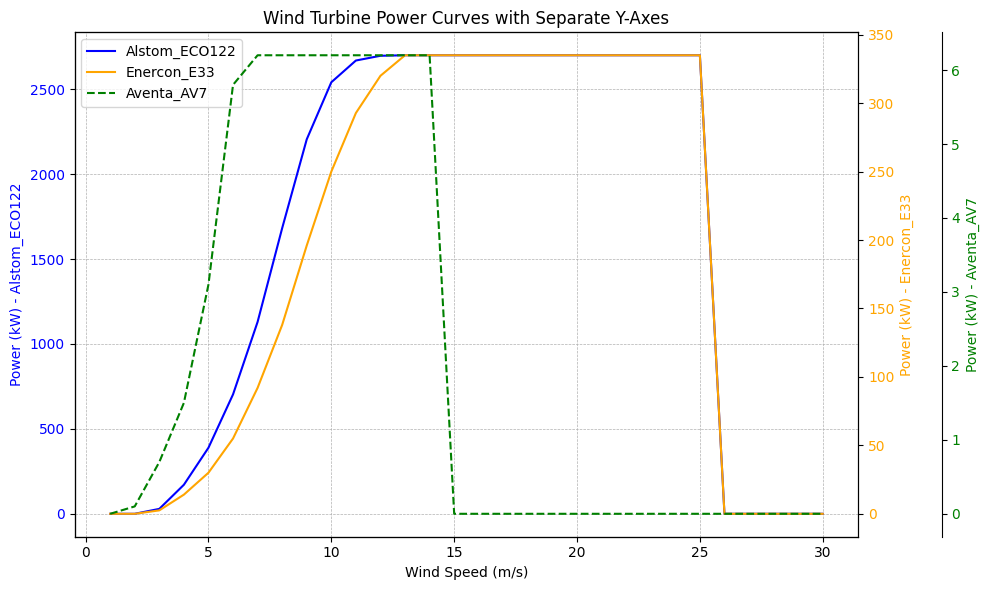

In [16]:
turbines = get_turbines()

fig, ax1 = plt.subplots(figsize=(10, 6))

#Plot for Alstom 
name = 'Alstom_ECO122'
wind_speeds = np.array(list(turbines[name]['power_curve'].keys()))
powers = np.array(list(turbines[name]['power_curve'].values()))
ax1.plot(wind_speeds, powers, label=name, color='blue')
ax1.set_xlabel('Wind Speed (m/s)')
ax1.set_ylabel('Power (kW) - Alstom_ECO122', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

#plot for Enercon
ax2 = ax1.twinx()
name = 'Enercon_E33'
wind_speeds = np.array(list(turbines[name]['power_curve'].keys()))
powers = np.array(list(turbines[name]['power_curve'].values()))
ax2.plot(wind_speeds, powers, label=name, color='orange')
ax2.set_ylabel('Power (kW) - Enercon_E33', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

#plot for Aventa
ax3 = ax1.twinx()
name = 'Aventa_AV7'
wind_speeds = np.array(list(turbines[name]['power_curve'].keys()))
powers = np.array(list(turbines[name]['power_curve'].values()))
ax3.plot(wind_speeds, powers, label=name, color='green', linestyle='--')

#Offset Aventa to the right so it doesn't overlap with Enercon
ax3.spines["right"].set_position(("outward", 60))
ax3.set_ylabel('Power (kW) - Aventa_AV7', color='green')
ax3.tick_params(axis='y', labelcolor='green')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')
ax1.grid(True, linestyle='--', linewidth=0.5)
plt.title('Wind Turbine Power Curves with Separate Y-Axes')
plt.tight_layout()
plt.show()

----- To be able to calculate the number of operating hours and power production for each turbine, we need to use the power curve to convert wind speed into KW/h and also take the cut in/ cut out wind speed into account as this will influence the working hours. 

We will also need the weibull distribution for each turbine at hub height. Since we will calculate the expected power output by integrating the product in the interpolated power curve and the weibull probability density function,  restricted to the turbine's operating range defined by its cut-in and cut-out wind speeds-----

Weibull‐Based Energy & Capacity Factors (Fast Approach)


,Weibull k,Weibull λ,Cut-in Speed (m/s),Cut-out Speed (m/s),Rated Power (kW),Average Power (kW),Operating Hours,Annual Energy (kWh),Capacity Factor (%)
Turbine,,,,,,,,,
Alstom_ECO122,2.157495,10.706426,3.0,25.0,2700.0,1735.125780,8197.570148,1.519970e+07,64.263918
Enercon_E33,2.184729,9.912605,2.5,25.0,330.0,170.047088,8333.841915,1.489612e+06,51.529421
Aventa_AV7,2.203678,9.259863,2.0,14.0,6.5,4.376059,7737.225193,3.833427e+04,67.323981


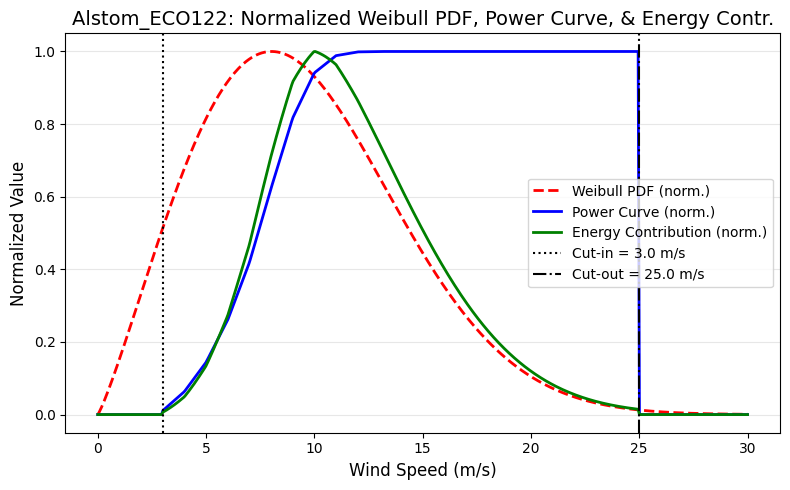

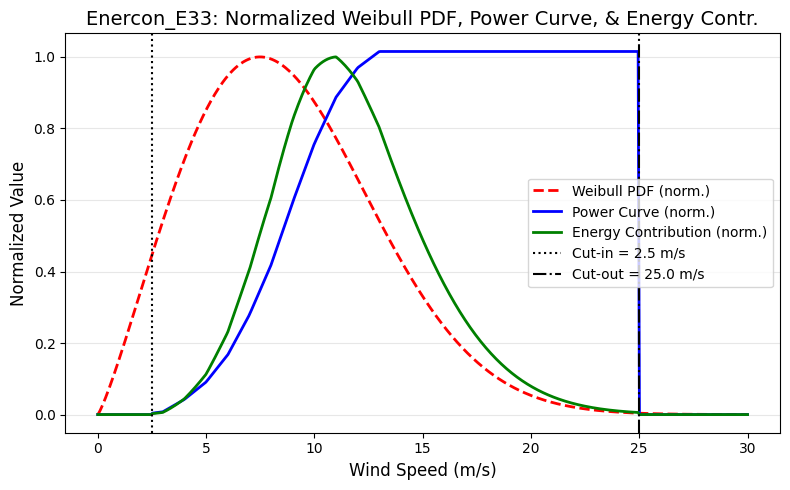

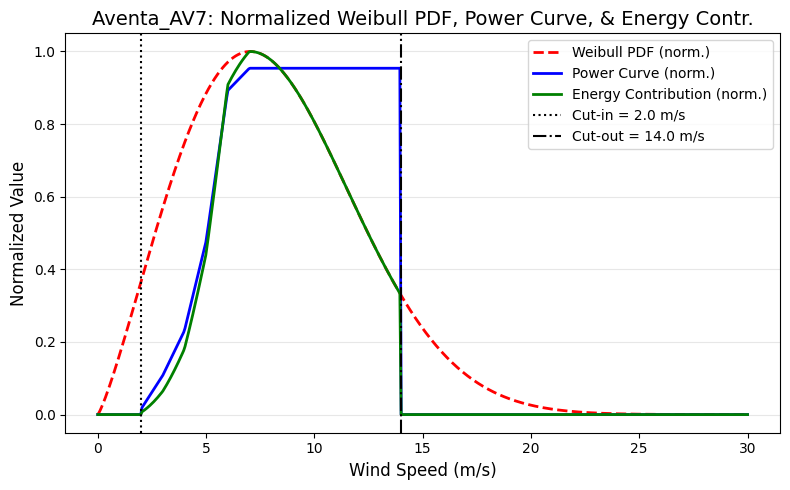

In [17]:
#Define a dense wind speed grid between (0-30 m/s)
GRID_SIZE = 500
wind_grid = np.linspace(0, 30, GRID_SIZE)   
delta_v = wind_grid[1] - wind_grid[0]       

#create a container for the output summary
summary = []

#for over each turbine extract hub height speeds and fit Weibull distribution
turbines = get_turbines()
for name, spec in turbines.items():
    col_name = f'wind_speed_{name}_from_logprofile'
    speeds = df[col_name].dropna().values
    shape_k, loc, scale_lambda = weibull_min.fit(speeds, floc=0)

    #interpolate power curve and compute expected power from Weibull PDF
    curve_keys   = np.array(list(spec['power_curve'].keys()))
    curve_vals   = np.array(list(spec['power_curve'].values()))
    power_func   = interp1d(curve_keys, curve_vals,
                            kind='linear',
                            bounds_error=False,
                            fill_value=0.0)
    pdf_vals     = weibull_min.pdf(wind_grid, shape_k, loc=0, scale=scale_lambda)
    power_vals   = power_func(wind_grid)
    power_vals[(wind_grid < spec['cut_in_speed']) | (wind_grid > spec['cut_out_speed'])] = 0.0
    expected_power = np.sum(power_vals * pdf_vals) * delta_v

    #Compute total operating hours
    total_hours = len(speeds) * 0.5     
    cdf_low   = weibull_min.cdf(spec['cut_in_speed'],  shape_k, loc=0, scale=scale_lambda)
    cdf_high  = weibull_min.cdf(spec['cut_out_speed'], shape_k, loc=0, scale=scale_lambda)
    prob_oper = cdf_high - cdf_low
    operating_hours = total_hours * prob_oper

    #Annual energy (kWh) and capacity factor (%)
    hours_per_year = 8760
    energy_kwh     = expected_power * hours_per_year
    cap_factor     = 100 * (energy_kwh / (spec['rated_power'] * hours_per_year))

    #save results in summary
    summary.append({
        'Turbine':            name,
        'Weibull k':          shape_k,
        'Weibull λ':          scale_lambda,
        'Cut-in Speed (m/s)': spec['cut_in_speed'],
        'Cut-out Speed (m/s)': spec['cut_out_speed'],
        'Rated Power (kW)':   spec['rated_power'],
        'Average Power (kW)': expected_power,
        'Operating Hours':    operating_hours,
        'Annual Energy (kWh)':energy_kwh,
        'Capacity Factor (%)':cap_factor
    })

#create new DataFrame and save to CSV
results_df = pd.DataFrame(summary).set_index('Turbine')
print("Weibull‐Based Energy & Capacity Factors (Fast Approach)")
display(results_df)
df_out = df.copy()
for name in results_df.index:
    df_out[f'{name}_Operating_Hours']    = results_df.loc[name, 'Operating Hours']
    df_out[f'{name}_Annual_Energy_kWh']  = results_df.loc[name, 'Annual Energy (kWh)']
    df_out[f'{name}_Capacity_Factor_%']  = results_df.loc[name, 'Capacity Factor (%)']

df_out.to_csv('csv_Ouessant_2023_with_analytical_energy.csv', index=False)

#Plot 
for name, spec in turbines.items():
    shape_k   = results_df.loc[name, 'Weibull k']
    scale_lambda = results_df.loc[name, 'Weibull λ']
    rated_power  = spec['rated_power']
    cut_in       = spec['cut_in_speed']
    cut_out      = spec['cut_out_speed']
    curve_keys   = np.array(list(spec['power_curve'].keys()))
    curve_vals   = np.array(list(spec['power_curve'].values()))

    #Interpolate the same power curve onto wind_grid
    power_func = interp1d(curve_keys, curve_vals,
                          kind='linear', bounds_error=False, fill_value=0.0)
    power_vals = power_func(wind_grid)
    power_vals[(wind_grid < cut_in) | (wind_grid > cut_out)] = 0.0

    #Weibull PDF on the grid + normalise each curve
    pdf_vals = weibull_min.pdf(wind_grid, shape_k, loc=0, scale=scale_lambda)
    pdf_norm   = pdf_vals / np.max(pdf_vals)
    power_norm = power_vals / rated_power
    energy_contrib = power_vals * pdf_vals * hours_per_year
    energy_norm    = energy_contrib / np.max(energy_contrib)

    #Plot 3 turbines
    plt.figure(figsize=(8, 5))
    plt.plot(wind_grid, pdf_norm,   'r--', linewidth=2, label='Weibull PDF (norm.)')
    plt.plot(wind_grid, power_norm, 'b-',  linewidth=2, label='Power Curve (norm.)')
    plt.plot(wind_grid, energy_norm,'g-',  linewidth=2, label='Energy Contribution (norm.)')

    plt.axvline(cut_in,  color='black', linestyle=':', linewidth=1.5, label=f'Cut-in = {cut_in} m/s')
    plt.axvline(cut_out, color='black', linestyle='-.', linewidth=1.5, label=f'Cut-out = {cut_out} m/s')

    plt.title(f"{name}: Normalized Weibull PDF, Power Curve, & Energy Contr.", fontsize=14)
    plt.xlabel("Wind Speed (m/s)", fontsize=12)
    plt.ylabel("Normalized Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

* The integration above has allowed us to compute the average power, which was multiplied by the number of hours in a year in order to compute the annual energy production in kWh. 

* The capacity factor was then calculated as the ratio of average power to rated power. 
* To determine operating hours, we used the Weibull distribution to compute the probability that wind speeds lie within the turbine’s cut in/cut out range. This probability was then multiplied by the total annual hours to estimate how long the turbine is expected to operate each year. 
* Finally, we saved the calculated metrics into a new csv file "csv_Ouessant_2023_with_analytical_energy" 

## 10) Automatize your pipeline of operations in order to be able to do it for any given year


Running full pipeline for year 2020.

Weibull‐Based Energy & Capacity Factors 


,Weibull k,Weibull λ,Cut-in Speed (m/s),Cut-out Speed (m/s),Rated Power (kW),Avg Power (kW),Operating Hours,Annual Energy (kWh),Capacity Factor (%)
Turbine,,,,,,,,,
Alstom_ECO122,2.180043,11.246117,3.0,25.0,2700.0,1811.319498,8275.625188,1.586716e+07,67.085907
Enercon_E33,2.180043,10.237537,2.5,25.0,330.0,177.039566,8378.878162,1.550867e+06,53.648353
Aventa_AV7,2.180043,9.409562,2.0,14.0,6.5,4.339570,7674.083231,3.801463e+04,66.762608


 Saved summary to: turbine_energy_summary_2020.csv

 Saved augmented dataset to: csv_Ouessant_2020_complete_analysis.csv



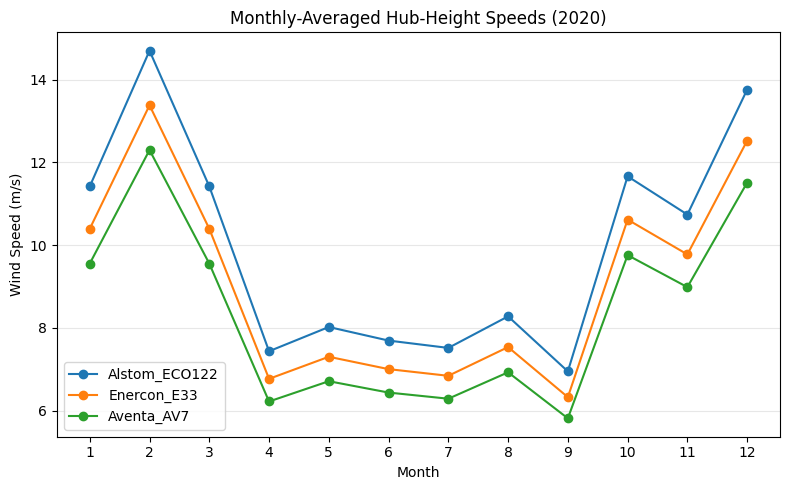

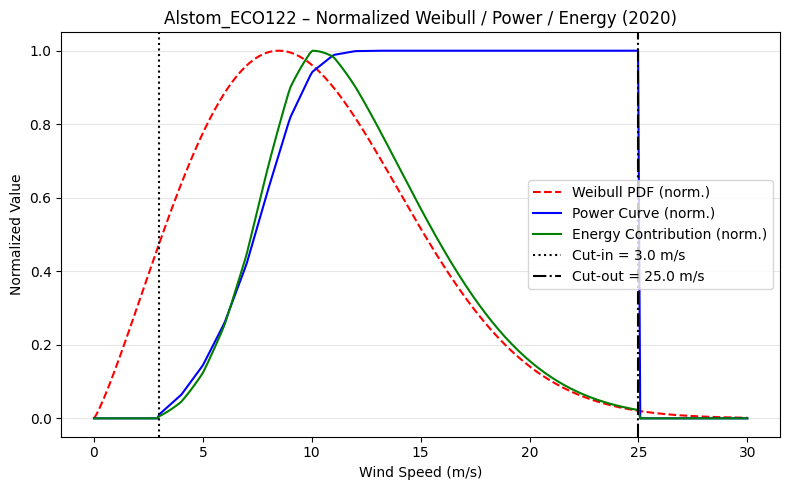

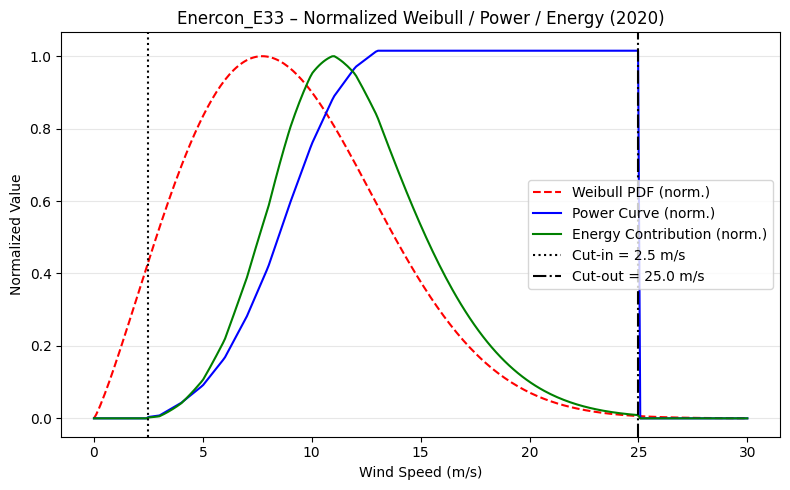

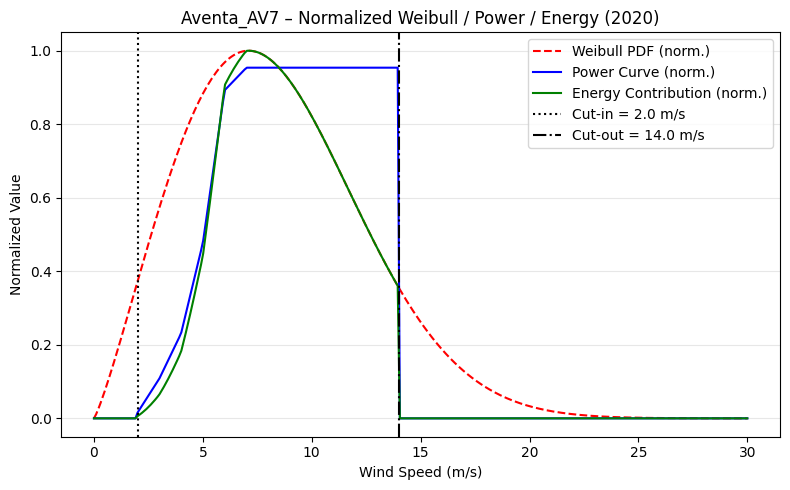

In [18]:
turbines = get_turbines()

#Load the data and process
def load_and_clean(year: int, master_filename: str = 'csv_Ouessant_48.455102_-5.097626_fixed_23_180_PT30M.csv') -> pd.DataFrame:
    if not os.path.isfile(master_filename):
        raise FileNotFoundError(f"Cannot find '{master_filename}' in the working directory.")

    df = pd.read_csv(master_filename, parse_dates=['period_end'])
    #Filter to the exact year:
    df = df[df['period_end'].dt.year == year].copy()
    df = df.dropna(subset=['wind_speed_10m', 'wind_speed_100m'])
    return df

#function to add log-profile hub speeds where we use 10m and 100m speeds for each turbine
def add_logprofile_hub_speeds(df: pd.DataFrame, z0=0.005, d=0.0) -> pd.DataFrame:
    z1 = 10.0
    z2 = 100.0
    ln_z1 = np.log((z1 - d) / z0)
    ln_z2 = np.log((z2 - d) / z0)

    for name, spec in turbines.items():
        h = spec['hub_height']
        ln_h = np.log((h - d) / z0)

        #Factor to go from 10m to hub height:
        factor10 = ln_h / ln_z1
        df[f'wind_speed_{name}_from_10m'] = df['wind_speed_10m'] * factor10

        #Factor to go from 100m to hub height:
        factor100 = ln_h / ln_z2
        df[f'wind_speed_{name}_from_100m'] = df['wind_speed_100m'] * factor100

        #store the average of the two
        df[f'wind_speed_{name}_from_logprofile'] = 0.5 * (
            df[f'wind_speed_{name}_from_10m'] +
            df[f'wind_speed_{name}_from_100m']
        )

    return df

#function to compute monthly averages for each turbine given a DataFrame containing "period_end" and wind speed columns
def compute_monthly_averages(df: pd.DataFrame) -> pd.DataFrame:
    df['month'] = df['period_end'].dt.month
    monthly = {}
    for name in turbines.keys():
        col = f'wind_speed_{name}_from_logprofile'
        monthly[f'{name}_monthly_avg'] = df.groupby('month')[col].mean()
    monthly_df = pd.DataFrame(monthly)
    monthly_df.index.name = 'month'
    return monthly_df

#function where for each turbine, we fit a Weibull distribution, compute energy metrics, and return a summary DataFrame
def fit_weibull_and_energy_metrics(df: pd.DataFrame) -> pd.DataFrame:
    GRID_SIZE = 500
    wind_grid = np.linspace(0, 30, GRID_SIZE)
    delta_v = wind_grid[1] - wind_grid[0]
    hours_per_year = 8760

    summary = []
    for name, spec in turbines.items():
        col = f'wind_speed_{name}_from_logprofile'
        speeds = df[col].dropna().values

        #Fit Weibull distribution and interpolate the turbine's power curve
        shape_k, loc, scale = weibull_min.fit(speeds, floc=0)
        keys = np.array(list(spec['power_curve'].keys()))
        vals = np.array(list(spec['power_curve'].values()))
        power_interp = interp1d(keys, vals, kind='linear', bounds_error=False, fill_value=0.0)

        #Compute expected power from the Weibull PDF on the wind grid
        pdf_vals = weibull_min.pdf(wind_grid, shape_k, loc=0, scale=scale)
        p_vals   = power_interp(wind_grid)
        ci, co = spec['cut_in_speed'], spec['cut_out_speed']
        mask_on = (wind_grid >= ci) & (wind_grid <= co)
        p_vals[~mask_on] = 0.0
        E_power = np.sum(p_vals * pdf_vals) * delta_v

        #Calculate operating hours, annual energy, capacity factor, and store results
        cdf_low  = weibull_min.cdf(ci, shape_k, loc=0, scale=scale)
        cdf_high = weibull_min.cdf(co, shape_k, loc=0, scale=scale)
        total_intervals = len(speeds)
        total_hours     = total_intervals * 0.5
        op_hours = total_hours * (cdf_high - cdf_low)
        energy = E_power * hours_per_year
        capf   = 100 * energy / (spec['rated_power'] * hours_per_year)

        summary.append({
            'Turbine':             name,
            'Weibull k':           shape_k,
            'Weibull λ':           scale,
            'Cut-in Speed (m/s)':  ci,
            'Cut-out Speed (m/s)': co,
            'Rated Power (kW)':    spec['rated_power'],
            'Avg Power (kW)':      E_power,
            'Operating Hours':     op_hours,
            'Annual Energy (kWh)': energy,
            'Capacity Factor (%)': capf
        })

    return pd.DataFrame(summary).set_index('Turbine')

#function that plots the monthly‐averaged hub‐height speeds as well as the normalized Weibull PDF, power curve, and energy contribution for each turbine
def plot_distributions(df: pd.DataFrame, year: int) -> None:
    monthly_df = compute_monthly_averages(df) #monthly averages
    months = monthly_df.index.values

    plt.figure(figsize=(8, 5))
    for name in turbines.keys():
        plt.plot(
            months,
            monthly_df[f'{name}_monthly_avg'],
            marker='o',
            linestyle='-',
            label=name
        )
    plt.title(f'Monthly‐Averaged Hub‐Height Speeds ({year})')
    plt.xlabel('Month')
    plt.ylabel('Wind Speed (m/s)')
    plt.xticks(np.arange(1, 13))
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    #Normalized energy contributions per turbine
    GRID_SIZE = 300
    wind_grid = np.linspace(0, 30, GRID_SIZE)
    hours_per_year = 8760

    for name, spec in turbines.items():
       #Fit Weibull to hub‐height speeds and build power‐curve interpolator
        speeds = df[f'wind_speed_{name}_from_logprofile'].dropna().values
        shape_k, loc, scale = weibull_min.fit(speeds, floc=0)
        keys = np.array(list(spec['power_curve'].keys()))
        vals = np.array(list(spec['power_curve'].values()))
        power_interp = interp1d(keys, vals, kind='linear', bounds_error=False, fill_value=0.0)

        #Evaluate on the grid
        pdf_vals = weibull_min.pdf(wind_grid, shape_k, loc=0, scale=scale)
        p_vals   = power_interp(wind_grid)
        ci, co = spec['cut_in_speed'], spec['cut_out_speed']
        p_vals[(wind_grid < ci) | (wind_grid > co)] = 0.0

        #Normalize each curve
        pdf_norm   = pdf_vals / pdf_vals.max()
        power_norm = p_vals / spec['rated_power']
        energy     = p_vals * pdf_vals * hours_per_year
        energy_norm = energy / energy.max()

        #Plot
        plt.figure(figsize=(8, 5))
        plt.plot(wind_grid, pdf_norm,    'r--', label='Weibull PDF (norm.)')
        plt.plot(wind_grid, power_norm,  'b-',  label='Power Curve (norm.)')
        plt.plot(wind_grid, energy_norm, 'g-',  label='Energy Contribution (norm.)')
        plt.axvline(ci, color='black', linestyle=':', label=f'Cut-in = {ci} m/s')
        plt.axvline(co, color='black', linestyle='-.', label=f'Cut-out = {co} m/s')

        plt.title(f"{name} – Normalized Weibull / Power / Energy ({year})")
        plt.xlabel("Wind Speed (m/s)")
        plt.ylabel("Normalized Value")
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

#Main “pipeline” function
def run_pipeline(year: int):
    print(f"\nRunning full pipeline for year {year}.\n")

    #Load & clean from the MASTER file then extrapolate to hub heights
    df_year = load_and_clean(year)
    df_with_hub = add_logprofile_hub_speeds(df_year)

    #compute Weibull‐based metrics and save summary CSV
    summary_df = fit_weibull_and_energy_metrics(df_with_hub)
    print("Weibull‐Based Energy & Capacity Factors ")
    display(summary_df)
    summary_csv = f'turbine_energy_summary_{year}.csv'
    summary_df.to_csv(summary_csv)
    print(f" Saved summary to: {summary_csv}\n")
    df_out = df_with_hub.copy()
    for name in summary_df.index:
        df_out[f'{name}_Operating_Hours']   = summary_df.loc[name, 'Operating Hours']
        df_out[f'{name}_Annual_Energy_kWh'] = summary_df.loc[name, 'Annual Energy (kWh)']
        df_out[f'{name}_Capacity_Factor_%'] = summary_df.loc[name, 'Capacity Factor (%)']

    out_csv = f'csv_Ouessant_{year}_complete_analysis.csv'
    df_out.to_csv(out_csv, index=False)
    print(f" Saved augmented dataset to: {out_csv}\n")

    #Plot time‐series and distributions
    plot_distributions(df_with_hub, year)

#determine year here
if __name__ == '__main__':
    import sys
    #See if we’re in a notebook
    if len(sys.argv) == 1 or 'ipykernel' in sys.argv[0].lower():
        year_arg = 2020  #insert year here
    else:
        try:
            year_arg = int(sys.argv[1])
        except ValueError:
            raise ValueError("Please supply a valid integer year, e.g. 2023 or 2024.")

    run_pipeline(year_arg)


We have automatised our pipeline of operation above. By inputting the year of interest (between 2014-2023) at the end of the code (year_arg = ...), the pipeline will produce the above chart and calculate the number of opertating hours, yearly power production and capacity factor for each turbine. 

## 11) Plot the capacity factor as a function of 1) the month, and 2) the year

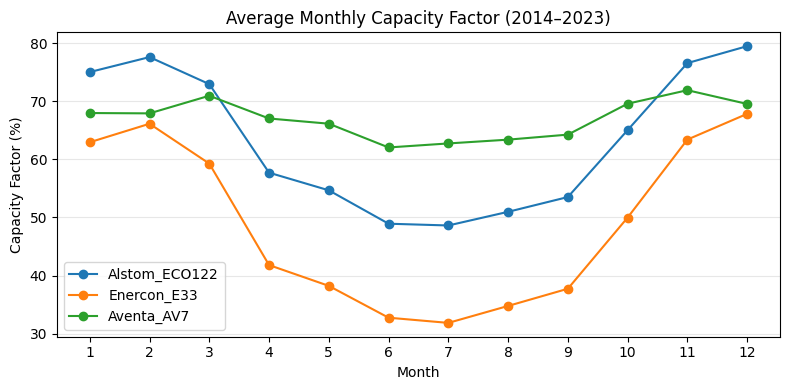

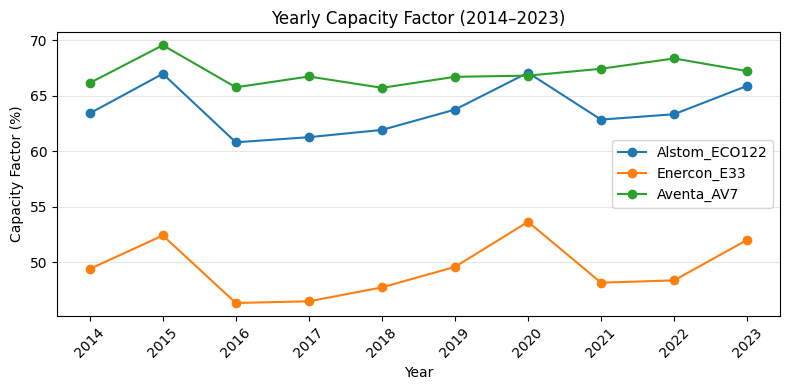

In [19]:
#Load the master file and add hub‐height columns
master = pd.read_csv(
    'csv_Ouessant_48.455102_-5.097626_fixed_23_180_PT30M.csv',
    parse_dates=['period_end']
)
master = master.dropna(subset=['wind_speed_10m','wind_speed_100m'])
master = add_logprofile_hub_speeds(master)

#Extract the year and month, and then drop any 2024 rows
master['year']  = master['period_end'].dt.year
master['month'] = master['period_end'].dt.month
master = master[master['year'] < 2024].copy()

#compute capcity factor from hub speeds
def _compute_cf(speeds, spec, GRID=300):
    shape_k, loc, scale = weibull_min.fit(speeds, floc=0)
    grid   = np.linspace(0, 30, GRID)
    dv     = grid[1] - grid[0]
    pdf    = weibull_min.pdf(grid, shape_k, loc=0, scale=scale)
    ks = np.array(list(spec['power_curve'].keys()))
    vs = np.array(list(spec['power_curve'].values()))
    pfn = interp1d(ks, vs, kind='linear', bounds_error=False, fill_value=0.0)
    P    = pfn(grid)
    ci, co = spec['cut_in_speed'], spec['cut_out_speed']
    P[(grid < ci) | (grid > co)] = 0.0
    EP   = np.sum(P * pdf) * dv
    return 100.0 * EP / spec['rated_power']

#Compute capacity factor for each month from 2014–2023
months = np.arange(1, 13)
monthly_cf = {name: [] for name in turbines}
for m in months:
    sub = master[master['month'] == m]
    for name, spec in turbines.items():
        arr = sub[f'wind_speed_{name}_from_logprofile'].dropna().values
        if arr.size < 10:
            monthly_cf[name].append(np.nan)
        else:
            monthly_cf[name].append(_compute_cf(arr, spec))

#Plot capacity factor vs Month
plt.figure(figsize=(8, 4))
for name in turbines:
    plt.plot(months, monthly_cf[name], marker='o', label=name)
plt.xticks(months)
plt.xlabel("Month")
plt.ylabel("Capacity Factor (%)")
plt.title("Average Monthly Capacity Factor (2014–2023)")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#List all unique years < 2024
years = sorted(master['year'].unique())
yearly_cf = {name: [] for name in turbines}
for y in years:
    sub = master[master['year'] == y]
    for name, spec in turbines.items():
        arr = sub[f'wind_speed_{name}_from_logprofile'].dropna().values
        if arr.size < 10:
            yearly_cf[name].append(np.nan)
        else:
            yearly_cf[name].append(_compute_cf(arr, spec))

#Plot Capacity factor vs Year
plt.figure(figsize=(8, 4))
for name in turbines:
    plt.plot(years, yearly_cf[name], marker='o', label=name)
plt.xticks(years, rotation=45)
plt.xlabel("Year")
plt.ylabel("Capacity Factor (%)")
plt.title("Yearly Capacity Factor (2014–2023)")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Using our pipeline we can plot the average monthly capacity factor for each turbine from 2014 to 2023, and the yearly capacity factor from 2014 to 2023.

## 12) How many wind turbines of each of those kinds would you need to install to safely power the town you have chosen with only wind turbines?

Source: 
https://fr.wikipedia.org/wiki/Ouessant 

In [20]:
#the list of years to process
years = list(range(2014, 2024))

#the container for each year’s “Annual Energy (kWh)”
annual_energy_records = []

for year in years:
    df_year = load_and_clean(year)
    df_with_hub = add_logprofile_hub_speeds(df_year)
    summary_df = fit_weibull_and_energy_metrics(df_with_hub)
    
    #Extract the “Annual Energy (kWh)” column and label it with the year
    energies = summary_df["Annual Energy (kWh)"]
    energies.name = year
    annual_energy_records.append(energies)

#Now combine into a DataFrame
annual_energy_df = pd.DataFrame(annual_energy_records, index=years)

#next compute the 10-year average for each turbine
average_energy = annual_energy_df.mean()
print("Annual Energy by Year (kWh)")
display(annual_energy_df)
avg_df = average_energy.to_frame(name="Avg Annual Energy (kWh)").reset_index().rename(columns={"index": "Turbine"})
print("\n10-Year Average Annual Energy (2014–2023) (kWh)")
display(avg_df.set_index("Turbine"))

#Compute number of turbines needed for Ouessant
total_demand = 854 * 2_223  # = 1 898 442 kWh/yr

num_turbines = {}
for turb, avg_kwh in average_energy.items():
    needed = np.ceil(total_demand / avg_kwh)
    num_turbines[turb] = int(needed)

#Create DataFrame for counts
turbine_counts_df = (
    pd.DataFrame.from_dict(num_turbines, orient="index", columns=["Units Needed"])
      .reset_index()
      .rename(columns={"index": "Turbine"})
)
print("\nNumber of Turbines Needed (Ouessant)")
display(turbine_counts_df.set_index("Turbine"))

Annual Energy by Year (kWh)


Turbine,Alstom_ECO122,Enercon_E33,Aventa_AV7
2014,1.500134e+07,1.428226e+06,37644.416318
2015,1.584456e+07,1.515415e+06,39580.182652
2016,1.438391e+07,1.339412e+06,37426.946414
2017,1.449358e+07,1.343902e+06,37982.341334
2018,1.464778e+07,1.380057e+06,37397.685536
2019,1.508072e+07,1.433528e+06,37960.467339
2020,1.586716e+07,1.550867e+06,38014.629099
2021,1.486776e+07,1.392358e+06,38376.653267
2022,1.498281e+07,1.398407e+06,38907.079205
2023,1.558671e+07,1.503804e+06,38250.219463



10-Year Average Annual Energy (2014–2023) (kWh)


,Avg Annual Energy (kWh)
Turbine,
Alstom_ECO122,1.507563e+07
Enercon_E33,1.428598e+06
Aventa_AV7,3.815406e+04



Number of Turbines Needed (Ouessant)


,Units Needed
Turbine,
Alstom_ECO122,1
Enercon_E33,2
Aventa_AV7,50


Ouessant needs at least 1 898 442 kWh/yr for the whole population. So 1 Alstom turbine is to large for what is needed. We are left with either the Enercon (2) or the Aventa (50). Lets do a cost analysis.

## 13) What choice would you make based on cost and feasibility?

Sources:
https://wteinternational.com/news/alstom-to-supply-36-units-of-eco-122-wind-turbines-for-trairi-ii-project/

https://westpenninesprotectiontrust.co.uk/wp-content/uploads/2012/06/PDF-101106-Enercon-E33-Flyer-energy-production-return-claimed.pdf

https://www.fcn.eonerc.rwth-aachen.de/global/show_document.asp?id=aaaaaaaaaagvvyb

Prices: 

Alstom ECO122 = 3,333 M€

Enercon E33 = 700 K€

Aventa AV7 = 93 K€


In [21]:
# Static turbine data
unit_costs = { 
    "Alstom_ECO122": 3_333_000,
    "Enercon_E33":   700_000,
    "Aventa_AV7":     93_000     
}

installation_costs = {
    "Alstom_ECO122": 2_700_000,
    "Enercon_E33":   330_000,
    "Aventa_AV7":      6_500
}

power_rating = {
    "Alstom_ECO122": 2.7,
    "Enercon_E33":   0.33,
    "Aventa_AV7":    0.0065
}

turbine_display_names = {
    "Alstom_ECO122": "Alstom ECO122",
    "Enercon_E33": "Enercon E33",
    "Aventa_AV7": "Aventa AV7"
}

# Constants
edf_price_per_kwh = 0.2016
lifetime_years = 20
om_cost_per_mw_per_year = 30_000

# Begin cost analysis
print("\n=== Cost Analysis for Ouessant ===")
rows = []

for turb in ["Alstom_ECO122", "Enercon_E33", "Aventa_AV7"]:
    display_name = turbine_display_names[turb]
    units = num_turbines[turb]
    avg_energy = average_energy[turb]  # kWh/year per unit

    if avg_energy <= 0 or units == "N/A":
        continue

    # Retrieve cost inputs
    turbine_cost = units * unit_costs[turb]
    install_cost = units * installation_costs[turb]
    capacity_mw = units * power_rating[turb]
    om_cost = capacity_mw * om_cost_per_mw_per_year * lifetime_years

    # Cost calculations
    upfront_cost = turbine_cost + install_cost
    lifetime_cost = upfront_cost + om_cost
    lifetime_energy = avg_energy * units * lifetime_years
    cost_per_kwh_lifetime = lifetime_cost / lifetime_energy
    net_revenue_per_kwh = edf_price_per_kwh - cost_per_kwh_lifetime
    net_lifetime_revenue = net_revenue_per_kwh * lifetime_energy
    net_payback_ratio = net_lifetime_revenue / lifetime_cost

    rows.append({
        "Turbine": display_name,
        "Units Needed": units,
        "Turbine Cost (€)": turbine_cost,
        "Installation Cost (€)": install_cost,
        "O&M Cost (€)": om_cost,
        "Upfront Cost (€)": upfront_cost,
        "Lifetime Cost (€)": lifetime_cost,
        "Avg Annual Energy (kWh/yr)": avg_energy,
        "Cost €/kWh (Lifetime)": cost_per_kwh_lifetime,
        "Net Revenue €/kWh": net_revenue_per_kwh,
        "Lifetime Net Revenue (€)": net_lifetime_revenue,
        "Net Payback Ratio": net_payback_ratio
    })

df_cost = pd.DataFrame(rows).set_index("Turbine")
pd.set_option("display.float_format", "{:,.4f}".format)
display(df_cost)



=== Cost Analysis for Ouessant ===


,Units Needed,Turbine Cost (€),Installation Cost (€),O&M Cost (€),Upfront Cost (€),Lifetime Cost (€),Avg Annual Energy (kWh/yr),Cost €/kWh (Lifetime),Net Revenue €/kWh,Lifetime Net Revenue (€),Net Payback Ratio
Turbine,,,,,,,,,,,
Alstom ECO122,1,3333000,2700000,"1,620,000.0000",6033000,"7,653,000.0000","15,075,633.2529",0.0254,0.1762,"53,131,953.2758",6.9426
Enercon E33,2,1400000,660000,"396,000.0000",2060000,"2,456,000.0000","1,428,597.5245",0.0430,0.1586,"9,064,210.4373",3.6906
Aventa AV7,50,4650000,325000,"195,000.0000",4975000,"5,170,000.0000","38,154.0621",0.1355,0.0661,"2,521,858.9119",0.4878


In [22]:
# Define turbine models
turbines = ["Alstom ECO122", "Enercon E33", "Aventa AV7"]

# Lifetime energy production (from Excel data)
lifetime_energy_excel = {
    "Alstom ECO122": 376_890_750,
    "Enercon E33": 71_429_900,
    "Aventa AV7": 47_692_500
}

# Number of units per turbine
units_needed = {
    "Alstom ECO122": 1,
    "Enercon E33": 2,
    "Aventa AV7": 50
}

# Power rating per unit (MW)
power_rating = {
    "Alstom ECO122": 2.7,
    "Enercon E33": 0.33,
    "Aventa AV7": 0.0065
}

# Turbine unit cost (€)
unit_costs = {
    "Alstom ECO122": 3_333_000,
    "Enercon E33": 700_000,
    "Aventa AV7": 93_000
}

# Installation cost per unit (€)
installation_costs = {
    "Alstom ECO122": 2_700_000,
    "Enercon E33": 330_000,
    "Aventa AV7": 6_500
}

# Battery system cost (€)
battery_costs = {
    "Alstom ECO122": 548_000,
    "Enercon E33": 548_000,
    "Aventa AV7": 685_000
}

# Constants
om_cost_per_mw_per_year = 30_000  # €/MW/year
lifetime_years = 25
edf_price_per_kwh = 0.2016  # €/kWh

# Build cost analysis table
rows = []
for turb in turbines:
    units = units_needed[turb]
    capacity_mw = units * power_rating[turb]
    turbine_cost = units * unit_costs[turb]
    installation_cost = units * installation_costs[turb]
    battery_cost = battery_costs[turb]
    om_cost = capacity_mw * om_cost_per_mw_per_year * lifetime_years
    upfront_cost = turbine_cost + installation_cost + battery_cost
    lifetime_cost = upfront_cost + om_cost
    lifetime_energy = lifetime_energy_excel[turb]
    cost_per_kwh = lifetime_cost / lifetime_energy
    net_revenue_per_kwh = edf_price_per_kwh - cost_per_kwh
    net_lifetime_revenue = net_revenue_per_kwh * lifetime_energy
    net_payback_ratio = net_lifetime_revenue / lifetime_cost

    rows.append({
        "Turbine": turb,
        "Units": units,
        "Installed Capacity (MW)": capacity_mw,
        "Turbine Cost (€)": turbine_cost,
        "Battery Cost (€)": battery_cost,
        "Installation Cost (€)": installation_cost,
        "O&M Cost (€)": om_cost,
        "Upfront Cost (€)": upfront_cost,
        "Lifetime Cost (€)": lifetime_cost,
        "Lifetime Energy (kWh)": lifetime_energy,
        "Cost per kWh (€)": cost_per_kwh,
        "Net Revenue per kWh (€)": net_revenue_per_kwh,
        "Lifetime Net Revenue (€)": net_lifetime_revenue,
        "Net Payback Ratio": net_payback_ratio
    })

# Convert to DataFrame
df_final_cost_analysis = pd.DataFrame(rows).set_index("Turbine")

# Show results
print("=== Final Cost and Payback Analysis ===\n")
print(df_final_cost_analysis.to_string(float_format="%.4f"))


=== Final Cost and Payback Analysis ===

               Units  Installed Capacity (MW)  Turbine Cost (€)  Battery Cost (€)  Installation Cost (€)  O&M Cost (€)  Upfront Cost (€)  Lifetime Cost (€)  Lifetime Energy (kWh)  Cost per kWh (€)  Net Revenue per kWh (€)  Lifetime Net Revenue (€)  Net Payback Ratio
Turbine                                                                                                                                                                                                                                                                   
Alstom ECO122      1                   2.7000           3333000            548000                2700000  2025000.0000           6581000       8606000.0000              376890750            0.0228                   0.1788             67375175.2000             7.8289
Enercon E33        2                   0.6600           1400000            548000                 660000   495000.0000           2608000       3103000.0000   

Summary of Economic Assessment – Wind Energy Options for Ouessant

This study compares the technical and economic viability of three wind turbine technologies (Alstom ECO122, Enercon E33, Aventa AV7) for deployment on the Isle of Ouessant, a protected natural area within a French regional park. All systems are assumed to operate for 25 years and are benchmarked against the regulated EDF “Tarif Bleu” of €0.2016/kWh.

Environmental & Site Considerations

The Alstom ECO122, while economically the most profitable, has a hub height of 89 m, making it visually intrusive and potentially noisier, which may not be suitable for the natural setting of Ouessant.

The Aventa AV7, though low-profile (18 m), would require 50 units, leading to high landscape fragmentation and civil works impact — environmentally disruptive for such a small island.

The Enercon E33, with a hub height of 37 m, represents a moderate scale, is less visually disruptive, and has low noise levels. It achieves a strong balance of cost, energy return, and environmental acceptability.

Conclusion

The Enercon E33 emerges as the most practical and responsible solution for the Isle of Ouessant, providing a balanced return on investment, manageable installation scale, and minimal environmental disruption, all while staying within economically viable margins compared to EDF's tariff.

https://particulier.edf.fr/content/dam/2-Actifs/Documents/Offres/Grille_prix_Tarif_Bleu.pdf

https://www.windpowermonthly.com/article/1335289/grasp-complexities-maintenance-costs?utm_source=chatgpt.com



As we can see the best option in terms of cost is the Enercon E33. This is because since we only need 2 units it makes it less degrading for the environnement, with a medium hub height to minimize visual impact. 

## 14) Assuming this electricity consumption is constant, what storage capacity should your town install to deal with periods without wind?

95th Percentile Gap and Required Storage for Each Turbine


,95th Percentile Gap (h),Storage Needed (kWh)
Turbine,,
Alstom_ECO122,17.0000,3684
Enercon_E33,15.5000,3359
Aventa_AV7,21.0000,4551


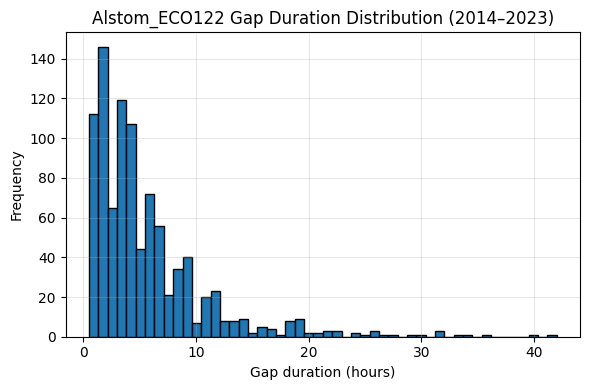

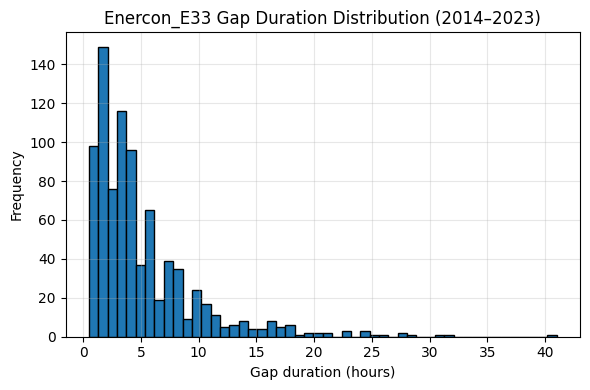

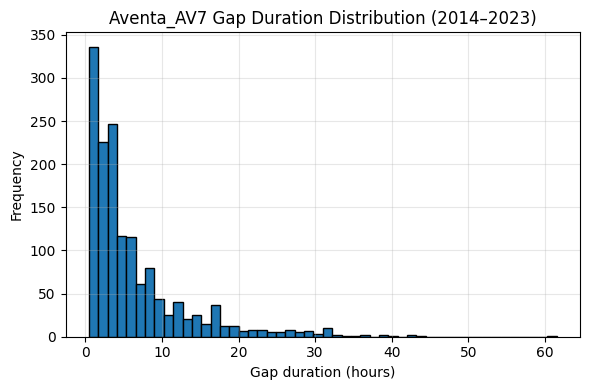

In [23]:
#load turbine specifications
turbines = get_turbines()

#functions from pipeline
def load_and_clean(year: int, master_filename: str = 'csv_Ouessant_48.455102_-5.097626_fixed_23_180_PT30M.csv') -> pd.DataFrame:
    if not os.path.isfile(master_filename):
        raise FileNotFoundError(f"Cannot find '{master_filename}'.")
    df = pd.read_csv(master_filename, parse_dates=['period_end'])
    df = df[df['period_end'].dt.year == year].copy()
    df = df.dropna(subset=['wind_speed_10m', 'wind_speed_100m'])
    return df

def add_logprofile_hub_speeds(df: pd.DataFrame, z0=0.005, d=0.0) -> pd.DataFrame:
    z1 = 10.0
    z2 = 100.0
    ln_z1 = np.log((z1 - d) / z0)  #the log‐profile exponent for this turbine’s hub height
    ln_z2 = np.log((z2 - d) / z0)
    for name, spec in turbines.items():
        h = spec['hub_height']
        ln_h = np.log((h - d) / z0)
        factor10 = ln_h / ln_z1   #scale 10m wind speed up to hub height
        df[f'wind_speed_{name}_from_10m'] = df['wind_speed_10m'] * factor10  
        factor100 = ln_h / ln_z2  #scale 100m wind speed up to hub height
        df[f'wind_speed_{name}_from_100m'] = df['wind_speed_100m'] * factor100
        df[f'wind_speed_{name}_from_logprofile'] = 0.5 * (
            df[f'wind_speed_{name}_from_10m'] +
            df[f'wind_speed_{name}_from_100m']
        )
    return df

#Extract gap durations for each turbine from 2014 - 2023
gap_durations = { name: [] for name in turbines.keys() }

for year in range(2014, 2024):
    df_year = load_and_clean(year)
    df_with_hub = add_logprofile_hub_speeds(df_year)
    df_with_hub = df_with_hub.rename(columns={'period_end': 'timestamp'})
    df_with_hub = df_with_hub.sort_values('timestamp').set_index('timestamp')
    
    for name, spec in turbines.items():
        hub_col = f'wind_speed_{name}_from_logprofile'
        ci = spec['cut_in_speed']
        co = spec['cut_out_speed']
        
        non_op = (df_with_hub[hub_col] < ci) | (df_with_hub[hub_col] > co) #here it identifies when the turbine is not operating (below cut‐in or above cut‐out)

        group_id = non_op.ne(non_op.shift(1)).cumsum()
        gap_runs = (df_with_hub[non_op]
                    .groupby(group_id)
                    .size() * 0.5)  #this converts intervals to hours
        positive_runs = gap_runs[gap_runs > 0].tolist()
        gap_durations[name].extend(positive_runs)


#Compute 95th percentile and battery size
population = 854
kwh_per_person = 2223
annual_demand_kwh = population * kwh_per_person  # = 1 898 442 kWh/yr
hours_per_year = 365 * 24                        # = 8 760 h/yr
average_load_kw = annual_demand_kwh / hours_per_year  # ≈ 216.7 kW

results = []
for name, durations in gap_durations.items():
    arr = np.array(durations)
    pct95 = np.percentile(arr, 95)
    storage_needed_kwh = average_load_kw * pct95
    results.append({
        'Turbine': name,
        '95th Percentile Gap (h)': round(pct95, 2),
        'Storage Needed (kWh)': int(round(storage_needed_kwh))
    })

df_storage = pd.DataFrame(results).set_index('Turbine')

print("95th Percentile Gap and Required Storage for Each Turbine")
display(df_storage)

#Plot
for name, durations in gap_durations.items():
    durations_arr = np.array(durations)
    plt.figure(figsize=(6, 4))
    plt.hist(durations_arr, bins=50, edgecolor='black')
    plt.title(f"{name} Gap Duration Distribution (2014–2023)")
    plt.xlabel("Gap duration (hours)")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


From 2014 to 2023, we used 10m and 100m wind data to estimate turbine hub‐height speeds and  then marked turbines “off” every 30 minutes if the wind was too low or too high. Next, we grouped consecutive off‐times into gaps, found the 95th‐percentile gap length over those ten years, and multiplied it by Ouessant’s average load (≈ 216.7 kW). That gives a battery requirement of about 4–5 MWh.

As of 2024, the average turnkey price for a utility-scale Li-ion battery is about $148 per kWh (so a 4 MWh system would cost roughly $148 × 4 000 kWh ≈ $592 000). This about 545K€ to add to the turbine costs

Source: https://liberalandlovingit.substack.com/p/the-cost-of-battery-energy-storage
